In [1]:
# Import necessary libraries
import os
import random
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image


import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split


Matplotlib created a temporary cache directory at /tmp/matplotlib-ocuffbdd because the default path (/gpfs/home/agarwv03/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Set the data path
data_path = "/gpfs/scratch/agarwv03/10_odor_dataset"

In [3]:
class OdorGlomeruliDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        # Dynamically get mouse folders
        mouse_folders = sorted(os.listdir(root_dir))
        
        # Dynamically get odorant folders from the first mouse folder
        first_mouse_dir = os.path.join(root_dir, mouse_folders[0])
        odorant_folders = sorted(os.listdir(first_mouse_dir))
        odorant_labels = {odor: idx for idx, odor in enumerate(odorant_folders)}

        for mouse in mouse_folders:
            mouse_path = os.path.join(root_dir, mouse)
            for odorant in odorant_folders:
                odor_path = os.path.join(mouse_path, odorant)
                images = sorted(os.listdir(odor_path))
                for img_name in images:
                    img_path = os.path.join(odor_path, img_name)
                    label = odorant_labels[odorant]
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, odor_label = self.data[idx]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return odor_label, image


In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


1952_mouse | Odorant '2_3_pentanedione': Mean=0.2955, Std=0.2011, Min=0.0000, Max=1.0000
1952_mouse | Odorant '2_4_dimethyl_acetophenone': Mean=0.2500, Std=0.1875, Min=0.0000, Max=1.0000
1952_mouse | Odorant '2_ethyl_butyric_acid': Mean=0.2648, Std=0.2046, Min=0.0000, Max=1.0000
1952_mouse | Odorant '2_methyl_butyraldehyde': Mean=0.2925, Std=0.2130, Min=0.0000, Max=1.0000
1952_mouse | Odorant '33_dimethyl_butyric_acid': Mean=0.2537, Std=0.2022, Min=0.0000, Max=1.0000
1952_mouse | Odorant '3_methylvaleric_acid': Mean=0.2310, Std=0.1964, Min=0.0000, Max=1.0000
1952_mouse | Odorant '4_heptanone': Mean=0.2344, Std=0.1935, Min=0.0000, Max=1.0000
1952_mouse | Odorant 'acetic_acid': Mean=0.3365, Std=0.2055, Min=0.0000, Max=1.0000
1952_mouse | Odorant 'gerinol': Mean=0.3207, Std=0.2030, Min=0.0000, Max=1.0000
1952_mouse | Odorant 'm_anisaldehyde': Mean=0.2998, Std=0.1949, Min=0.0000, Max=1.0000
1952_mouse | Odorant 'n_methyl_piperdine': Mean=0.2825, Std=0.2111, Min=0.0000, Max=1.0000
1953_mous

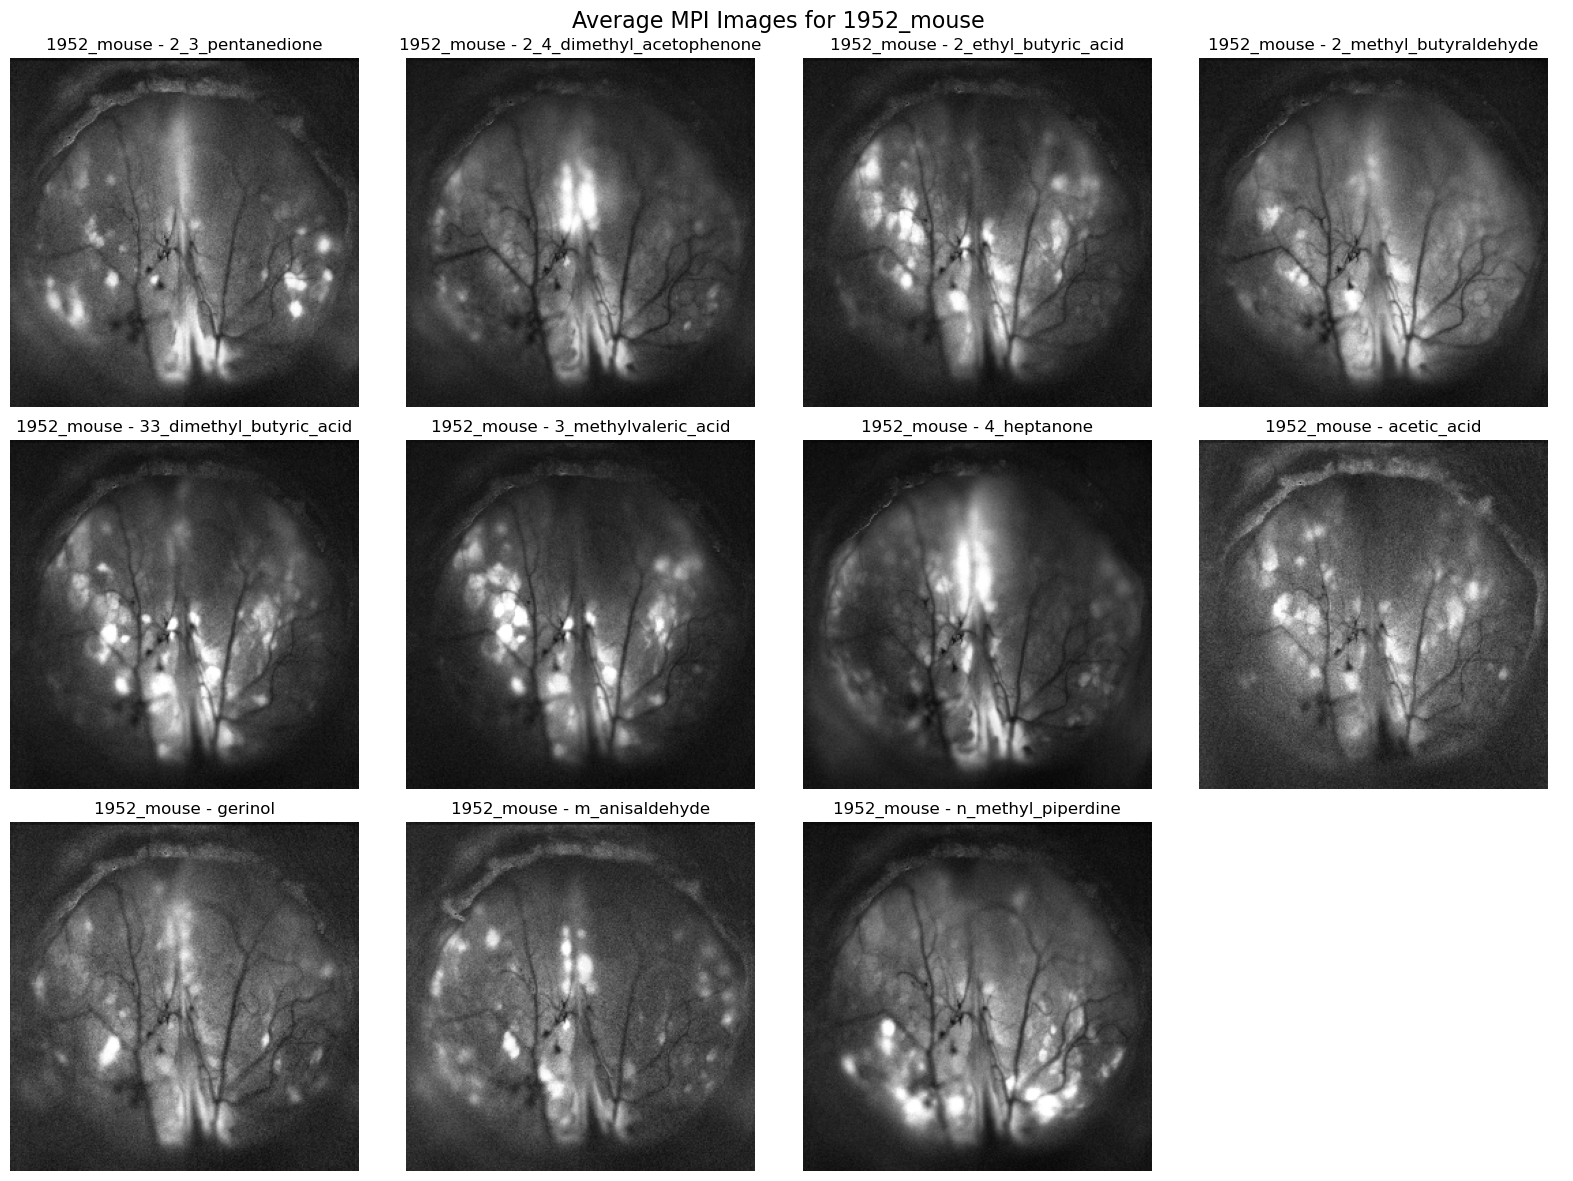

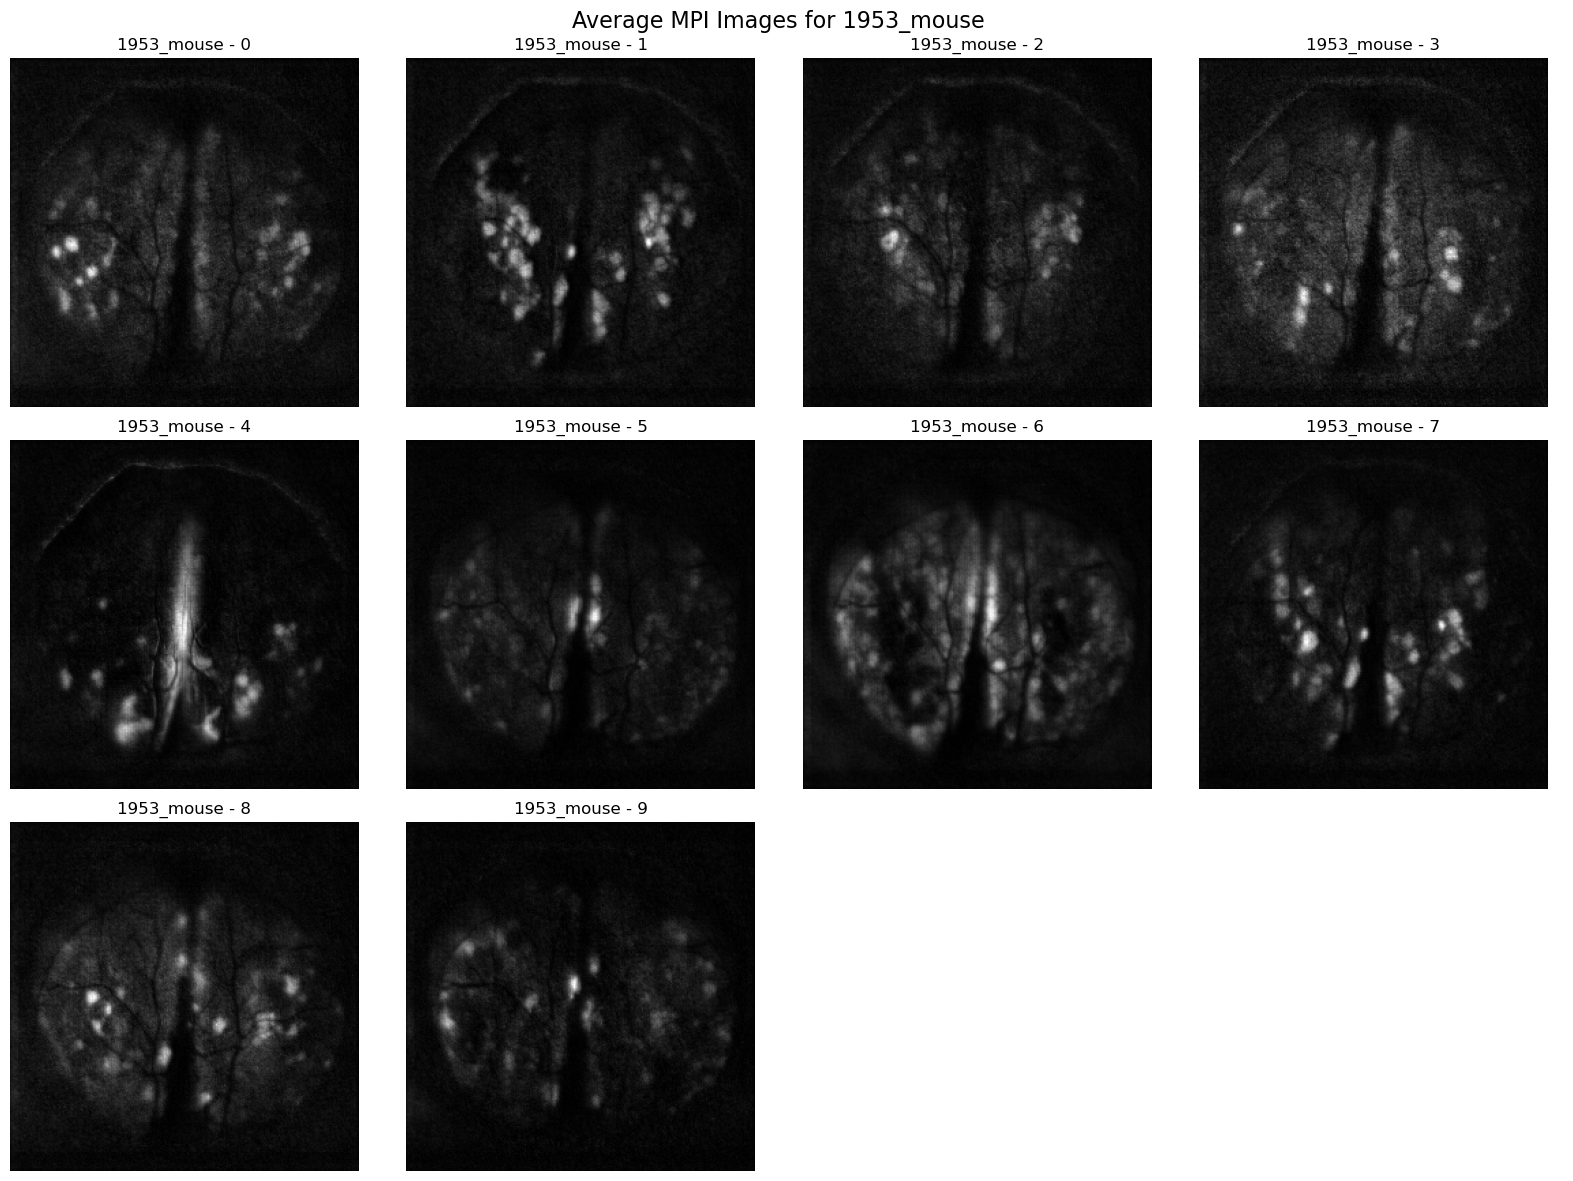

In [5]:

# Prepare mouse folders dynamically
mouse_folders = sorted(os.listdir(data_path))
odorant_stats = {}

for mouse in mouse_folders:
    mouse_path = os.path.join(data_path, mouse)
    odorant_folders = sorted(os.listdir(mouse_path))

    odorant_images = {odor: [] for odor in odorant_folders}

    # Load images
    for odorant in odorant_folders:
        odor_path = os.path.join(mouse_path, odorant)
        images = sorted(os.listdir(odor_path))

        for img_name in images:
            img_path = os.path.join(odor_path, img_name)
            image = Image.open(img_path).convert('L')
            image = transform(image).squeeze(0).numpy()
            odorant_images[odorant].append(image)

    # Compute stats per odorant clearly
    odorant_stats[mouse] = {}
    for odorant, images in odorant_images.items():
        images_array = np.stack(images)

        mean_val = images_array.mean()
        std_val = images_array.std()
        min_val = images_array.min()
        max_val = images_array.max()

        avg_image = images_array.mean(axis=0)

        odorant_stats[mouse][odorant] = {
            "mean": mean_val,
            "std": std_val,
            "min": min_val,
            "max": max_val,
            "avg_image": avg_image
        }

        print(f"{mouse} | Odorant '{odorant}': Mean={mean_val:.4f}, Std={std_val:.4f}, Min={min_val:.4f}, Max={max_val:.4f}")

#  visualize average MPI images mouse-wise
for mouse in mouse_folders:
    odorants = sorted(odorant_stats[mouse].keys())
    num_odorants = len(odorants)
    
    cols = 4
    rows = (num_odorants + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten()

    for idx, odorant in enumerate(odorants):
        ax = axes[idx]
        avg_img = odorant_stats[mouse][odorant]["avg_image"]
        ax.imshow(avg_img, cmap='gray')
        ax.set_title(f"{mouse} - {odorant}")
        ax.axis('off')

    # Hide unused subplots
    for idx in range(num_odorants, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f"Average MPI Images for {mouse}", fontsize=16)
    plt.tight_layout()
    plt.show()


#### lets start with - within mouse MINE appraoch 

In [6]:
class MINEWithinMouseDataset(Dataset):
    def __init__(self, root_dir, mouse_name, transform=None):
        self.transform = transform
        mouse_path = os.path.join(root_dir, mouse_name)
        self.data = []
        
        odorant_folders = sorted(os.listdir(mouse_path))
        self.odorant_labels = {odor: idx for idx, odor in enumerate(odorant_folders)}
        self.label_to_images = {idx: [] for idx in range(len(odorant_folders))}
        
        for odorant in odorant_folders:
            odor_path = os.path.join(mouse_path, odorant)
            images = sorted(os.listdir(odor_path))
            label = self.odorant_labels[odorant]
            
            for img_name in images:
                img_path = os.path.join(odor_path, img_name)
                self.label_to_images[label].append(img_path)
                self.data.append((img_path, label))
                
        self.labels = list(self.label_to_images.keys())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Joint pair
        img_path, odor_label = self.data[idx]
        joint_image = Image.open(img_path).convert('L')
        
        if self.transform:
            joint_image = self.transform(joint_image)
        
        # Marginal pair: image from random incorrect label
        random_label = odor_label
        while random_label == odor_label:
            random_label = random.choice(self.labels)
        
        marginal_img_path = random.choice(self.label_to_images[random_label])
        marginal_image = Image.open(marginal_img_path).convert('L')
        
        if self.transform:
            marginal_image = self.transform(marginal_image)

        return odor_label, joint_image, marginal_image


In [7]:

# Dynamically detect all mouse folders
mouse_folders = sorted(os.listdir(data_path))
print("Detected mouse folders:", mouse_folders)

# Now instantiate dataset clearly for each mouse separately:
datasets = {}
loaders = {}

for mouse in mouse_folders:
    dataset = MINEWithinMouseDataset(root_dir=data_path, mouse_name=mouse, transform=transform)
    loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    datasets[mouse] = dataset
    loaders[mouse] = loader
    print(f"{mouse}: {len(dataset)} samples loaded.")

# Quick verification  for one mouse
test_mouse = mouse_folders[1]
print(f"\nChecking data loader clearly for {test_mouse}:")

for odor_label, joint_img, marginal_img in loaders[test_mouse]:
    print("Odor labels shape:", odor_label.shape)
    print("Joint images shape:", joint_img.shape)
    print("Marginal images shape:", marginal_img.shape)
    break


Detected mouse folders: ['1952_mouse', '1953_mouse']
1952_mouse: 121 samples loaded.
1953_mouse: 500 samples loaded.

Checking data loader clearly for 1953_mouse:
Odor labels shape: torch.Size([8])
Joint images shape: torch.Size([8, 1, 256, 256])
Marginal images shape: torch.Size([8, 1, 256, 256])


In [8]:
class RobustCriticCNN(nn.Module):
    def __init__(self, num_odors=10, dropout_p=0.2):
        super(RobustCriticCNN, self).__init__()

        # CNN feature extractor
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128
            nn.Dropout2d(dropout_p),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64
            nn.Dropout2d(dropout_p),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32
            nn.Dropout2d(dropout_p),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # 1x1
        )

        # Odor label embedding
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_odors, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(64, 1)
        )

    def forward(self, odor_labels, images):
        img_feat = self.cnn_layers(images).view(images.size(0), -1)  # [batch,512]
        label_feat = self.label_embedding(odor_labels)               # [batch,128]

        combined = torch.cat([img_feat, label_feat], dim=1)          # [batch,640]
        output = self.fc(combined)                                   # [batch,1]

        return output


In [11]:
# Quick verification code
critic_model = RobustCriticCNN(num_odors=10)

dummy_labels = torch.randint(0, 10, (8,))           # batch size = 32
dummy_images = torch.randn(8, 1, 256, 256)          # batch size = 32, image shape = [1,256,256]

output = critic_model(dummy_labels, dummy_images)
print("Output shape:", output.shape)


Output shape: torch.Size([8, 1])


In [12]:
def wasserstein_loss(critic, odor_labels, joint_images, marginal_images):
    joint_scores = critic(odor_labels, joint_images)
    marginal_scores = critic(odor_labels, marginal_images)
    
    loss = -(torch.mean(joint_scores) - torch.mean(marginal_scores))
    wasserstein_estimate = -loss.item()
    
    return loss, wasserstein_estimate


In [13]:
def gradient_penalty(critic, odor_labels, joint_images, marginal_images, device):
    alpha = torch.rand(joint_images.size(0), 1, 1, 1).to(device)
    interpolated = alpha * joint_images + (1 - alpha) * marginal_images
    interpolated.requires_grad_(True)
    
    critic_scores = critic(odor_labels, interpolated)
    
    gradients = torch.autograd.grad(
        outputs=critic_scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    grad_norm = gradients.norm(2, dim=1)
    
    penalty = ((grad_norm - 1) ** 2).mean()
    
    return penalty


In [10]:
'''
# def f_divergence_loss(critic, odor_labels, joint_images, marginal_images):

def dv_loss(critic, odor_labels, joint_images, marginal_images):
    joint_scores = critic(odor_labels, joint_images)
    marginal_scores = critic(odor_labels, marginal_images)
    
    loss = -(torch.mean(joint_scores) - torch.mean(torch.exp(marginal_scores - 1)))
    mi_estimation = -loss.item()

    return loss, mi_estimation
'''

In [14]:
'''
def dv_loss(critic, odor_labels, joint_images, marginal_images):
    joint_scores = critic(odor_labels, joint_images)            # shape: [batch, 1]
    marginal_scores = critic(odor_labels, marginal_images)      # shape: [batch, 1]

    # DV Mutual Information estimation clearly:
    mi_estimation = torch.mean(joint_scores) - torch.log(torch.mean(torch.exp(marginal_scores)))
    
    # Loss is negative MI clearly (because we maximize MI)
    loss = -mi_estimation
    
    return loss, mi_estimation.item()
'''

In [17]:

# Initialize model
critic_model = RobustCriticCNN(num_odors=10)

# Dummy inputs for  verification
dummy_labels = torch.randint(0, 10, (8,))
joint_images = torch.randn(8, 1, 256, 256)
marginal_images = torch.randn(8, 1, 256, 256)

loss, estimate = wasserstein_loss(critic_model, dummy_labels, joint_images, marginal_images)

#loss, mi_estimate = dv_loss(critic_model, dummy_labels, joint_images, marginal_images)

print(f"Wass Loss: {loss.item():.4f}, MI Estimate: {estimate:.4f}")


Wass Loss: 0.0713, MI Estimate: -0.0713


In [23]:
def odorant_wise_split(dataset, train_trials_per_odor=35, test_trials_per_odor=15):
    # Organize indices by odorant clearly
    odor_to_indices = {}
    for idx, (label, _, _) in enumerate(dataset):  # Corrected here
        odor_to_indices.setdefault(label, []).append(idx)

    train_indices, test_indices = [], []

    # Split explicitly per odorant
    for odor_label, indices in odor_to_indices.items():
        assert len(indices) >= train_trials_per_odor + test_trials_per_odor, \
            f"Not enough trials for odor {odor_label}"
        random.shuffle(indices)
        train_indices += indices[:train_trials_per_odor]
        test_indices += indices[train_trials_per_odor:train_trials_per_odor + test_trials_per_odor]

    # Create datasets clearly
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    return train_dataset, test_dataset

# Usage example explicitly:
selected_mouse = '1953_mouse'
full_dataset = datasets[selected_mouse]

train_dataset, test_dataset = odorant_wise_split(full_dataset, train_trials_per_odor=35, test_trials_per_odor=15)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 350, Test samples: 150


In [25]:
num_epochs = 500
learning_rate = 1e-4
lambda_gp = 0.1  # Gradient penalty coefficient explicitly recommended
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

critic_model = RobustCriticCNN(num_odors=10, dropout_p=0.1).to(device)
optimizer = torch.optim.Adam(critic_model.parameters(), lr=learning_rate)

train_mi_history, test_mi_history = [], []

for epoch in range(num_epochs):
    critic_model.train()
    train_loss, train_estimate = 0.0, 0.0

    for odor_labels, joint_imgs, marginal_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        odor_labels, joint_imgs, marginal_imgs = odor_labels.to(device), joint_imgs.to(device), marginal_imgs.to(device)

        optimizer.zero_grad()

        # Wasserstein loss explicitly
        loss, estimate = wasserstein_loss(critic_model, odor_labels, joint_imgs, marginal_imgs)

        # Gradient penalty explicitly
        gp = gradient_penalty(critic_model, odor_labels, joint_imgs, marginal_imgs, device)

        total_loss = loss + lambda_gp * gp
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        train_estimate += estimate

    avg_train_loss = train_loss / len(train_loader)
    avg_train_estimate = train_estimate / len(train_loader)
    train_mi_history.append(avg_train_estimate)

    # Evaluation loop explicitly remains similar (but no GP needed explicitly)
    critic_model.eval()
    test_loss, test_estimate = 0.0, 0.0
    with torch.no_grad():
        for odor_labels, joint_imgs, marginal_imgs in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]"):
            odor_labels, joint_imgs, marginal_imgs = odor_labels.to(device), joint_imgs.to(device), marginal_imgs.to(device)
            
            loss, estimate = wasserstein_loss(critic_model, odor_labels, joint_imgs, marginal_imgs)
            
            test_loss += loss.item()
            test_estimate += estimate

    avg_test_loss = test_loss / len(test_loader)
    avg_test_estimate = test_estimate / len(test_loader)
    test_mi_history.append(avg_test_estimate)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Wasserstein: {avg_train_estimate:.4f}, Test Wasserstein: {avg_test_estimate:.4f}")

print("Wasserstein Training complete explicitly.")


Epoch 1/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.77it/s]


Epoch [1/500] - Train Wasserstein: -0.0140, Test Wasserstein: -0.0019


Epoch 2/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.91it/s]


Epoch [2/500] - Train Wasserstein: -0.0079, Test Wasserstein: -0.0095


Epoch 3/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.58it/s]


Epoch [3/500] - Train Wasserstein: 0.0105, Test Wasserstein: -0.0199


Epoch 4/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.62it/s]


Epoch [4/500] - Train Wasserstein: 0.0277, Test Wasserstein: 0.0190


Epoch 5/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.35it/s]


Epoch [5/500] - Train Wasserstein: 0.0003, Test Wasserstein: 0.0322


Epoch 6/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.88it/s]


Epoch [6/500] - Train Wasserstein: -0.0095, Test Wasserstein: 0.0306


Epoch 7/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.67it/s]


Epoch [7/500] - Train Wasserstein: 0.0110, Test Wasserstein: 0.0139


Epoch 8/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.78it/s]


Epoch [8/500] - Train Wasserstein: -0.0016, Test Wasserstein: 0.0082


Epoch 9/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.45it/s]


Epoch [9/500] - Train Wasserstein: -0.0073, Test Wasserstein: 0.0246


Epoch 10/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.24it/s]


Epoch [10/500] - Train Wasserstein: -0.0048, Test Wasserstein: 0.0130


Epoch 11/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.39it/s]


Epoch [11/500] - Train Wasserstein: 0.0062, Test Wasserstein: 0.0436


Epoch 12/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.62it/s]


Epoch [12/500] - Train Wasserstein: 0.0090, Test Wasserstein: 0.0441


Epoch 13/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.67it/s]


Epoch [13/500] - Train Wasserstein: -0.0057, Test Wasserstein: 0.0099


Epoch 14/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.26it/s]


Epoch [14/500] - Train Wasserstein: 0.0144, Test Wasserstein: -0.0020


Epoch 15/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.43it/s]


Epoch [15/500] - Train Wasserstein: 0.0086, Test Wasserstein: 0.0036


Epoch 16/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


Epoch [16/500] - Train Wasserstein: 0.0170, Test Wasserstein: 0.1269


Epoch 17/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.22it/s]


Epoch [17/500] - Train Wasserstein: -0.0038, Test Wasserstein: 0.0376


Epoch 18/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.14it/s]


Epoch [18/500] - Train Wasserstein: -0.0048, Test Wasserstein: 0.1038


Epoch 19/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.75it/s]


Epoch [19/500] - Train Wasserstein: 0.0332, Test Wasserstein: 0.0556


Epoch 20/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.56it/s]


Epoch [20/500] - Train Wasserstein: 0.0083, Test Wasserstein: 0.0587


Epoch 21/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.54it/s]


Epoch [21/500] - Train Wasserstein: 0.0237, Test Wasserstein: 0.1005


Epoch 22/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.49it/s]


Epoch [22/500] - Train Wasserstein: -0.0051, Test Wasserstein: 0.0244


Epoch 23/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.75it/s]


Epoch [23/500] - Train Wasserstein: 0.0248, Test Wasserstein: 0.0104


Epoch 24/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


Epoch [24/500] - Train Wasserstein: 0.0069, Test Wasserstein: 0.0202


Epoch 25/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.99it/s]


Epoch [25/500] - Train Wasserstein: 0.0171, Test Wasserstein: 0.0276


Epoch 26/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.70it/s]


Epoch [26/500] - Train Wasserstein: 0.0016, Test Wasserstein: 0.0143


Epoch 27/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.18it/s]


Epoch [27/500] - Train Wasserstein: 0.0121, Test Wasserstein: 0.0536


Epoch 28/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.56it/s]


Epoch [28/500] - Train Wasserstein: 0.0010, Test Wasserstein: 0.0028


Epoch 29/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.35it/s]


Epoch [29/500] - Train Wasserstein: 0.0114, Test Wasserstein: 0.0072


Epoch 30/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.95it/s]


Epoch [30/500] - Train Wasserstein: -0.0009, Test Wasserstein: 0.0542


Epoch 31/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.94it/s]


Epoch [31/500] - Train Wasserstein: 0.0120, Test Wasserstein: 0.0403


Epoch 32/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.71it/s]


Epoch [32/500] - Train Wasserstein: 0.0126, Test Wasserstein: 0.0416


Epoch 33/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.92it/s]


Epoch [33/500] - Train Wasserstein: 0.0232, Test Wasserstein: 0.0629


Epoch 34/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.22it/s]


Epoch [34/500] - Train Wasserstein: 0.0025, Test Wasserstein: 0.0460


Epoch 35/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.24it/s]


Epoch [35/500] - Train Wasserstein: 0.0359, Test Wasserstein: 0.0401


Epoch 36/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.35it/s]


Epoch [36/500] - Train Wasserstein: 0.0153, Test Wasserstein: 0.0073


Epoch 37/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.09it/s]


Epoch [37/500] - Train Wasserstein: -0.0111, Test Wasserstein: 0.1125


Epoch 38/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.14it/s]


Epoch [38/500] - Train Wasserstein: 0.0111, Test Wasserstein: 0.0246


Epoch 39/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.32it/s]


Epoch [39/500] - Train Wasserstein: 0.0226, Test Wasserstein: 0.0176


Epoch 40/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.75it/s]


Epoch [40/500] - Train Wasserstein: -0.0020, Test Wasserstein: 0.0417


Epoch 41/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.93it/s]


Epoch [41/500] - Train Wasserstein: 0.0103, Test Wasserstein: 0.0019


Epoch 42/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.86it/s]


Epoch [42/500] - Train Wasserstein: 0.0011, Test Wasserstein: 0.0275


Epoch 43/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.43it/s]


Epoch [43/500] - Train Wasserstein: -0.0013, Test Wasserstein: 0.0955


Epoch 44/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.80it/s]


Epoch [44/500] - Train Wasserstein: 0.0156, Test Wasserstein: 0.0872


Epoch 45/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.94it/s]


Epoch [45/500] - Train Wasserstein: 0.0264, Test Wasserstein: 0.0744


Epoch 46/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.98it/s]


Epoch [46/500] - Train Wasserstein: 0.0148, Test Wasserstein: 0.1055


Epoch 47/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.92it/s]


Epoch [47/500] - Train Wasserstein: 0.0345, Test Wasserstein: 0.0819


Epoch 48/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.17it/s]


Epoch [48/500] - Train Wasserstein: 0.0232, Test Wasserstein: 0.0530


Epoch 49/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.60it/s]


Epoch [49/500] - Train Wasserstein: -0.0020, Test Wasserstein: 0.0745


Epoch 50/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.96it/s]


Epoch [50/500] - Train Wasserstein: 0.0259, Test Wasserstein: 0.0656


Epoch 51/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.44it/s]


Epoch [51/500] - Train Wasserstein: 0.0209, Test Wasserstein: 0.0658


Epoch 52/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.15it/s]


Epoch [52/500] - Train Wasserstein: -0.0001, Test Wasserstein: 0.1220


Epoch 53/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.74it/s]


Epoch [53/500] - Train Wasserstein: 0.0254, Test Wasserstein: 0.0616


Epoch 54/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.02it/s]


Epoch [54/500] - Train Wasserstein: 0.0262, Test Wasserstein: 0.0273


Epoch 55/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.25it/s]


Epoch [55/500] - Train Wasserstein: 0.0179, Test Wasserstein: 0.0865


Epoch 56/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.62it/s]


Epoch [56/500] - Train Wasserstein: 0.0088, Test Wasserstein: 0.0585


Epoch 57/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.66it/s]


Epoch [57/500] - Train Wasserstein: 0.0207, Test Wasserstein: 0.0100


Epoch 58/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.46it/s]


Epoch [58/500] - Train Wasserstein: 0.0416, Test Wasserstein: 0.0660


Epoch 59/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.01it/s]


Epoch [59/500] - Train Wasserstein: 0.0515, Test Wasserstein: 0.0684


Epoch 60/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.51it/s]


Epoch [60/500] - Train Wasserstein: 0.0279, Test Wasserstein: 0.0715


Epoch 61/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.49it/s]


Epoch [61/500] - Train Wasserstein: 0.0267, Test Wasserstein: 0.1212


Epoch 62/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.27it/s]


Epoch [62/500] - Train Wasserstein: 0.0180, Test Wasserstein: 0.1504


Epoch 63/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.61it/s]


Epoch [63/500] - Train Wasserstein: 0.0322, Test Wasserstein: 0.1200


Epoch 64/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.48it/s]


Epoch [64/500] - Train Wasserstein: 0.0281, Test Wasserstein: 0.1690


Epoch 65/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


Epoch [65/500] - Train Wasserstein: 0.0292, Test Wasserstein: 0.0370


Epoch 66/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.04it/s]


Epoch [66/500] - Train Wasserstein: 0.0390, Test Wasserstein: 0.0685


Epoch 67/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.97it/s]


Epoch [67/500] - Train Wasserstein: 0.0220, Test Wasserstein: 0.1016


Epoch 68/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.96it/s]


Epoch [68/500] - Train Wasserstein: 0.0491, Test Wasserstein: 0.2091


Epoch 69/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.48it/s]


Epoch [69/500] - Train Wasserstein: 0.0110, Test Wasserstein: 0.1051


Epoch 70/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.80it/s]


Epoch [70/500] - Train Wasserstein: 0.0504, Test Wasserstein: 0.1469


Epoch 71/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.60it/s]


Epoch [71/500] - Train Wasserstein: 0.0302, Test Wasserstein: 0.0866


Epoch 72/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.07it/s]


Epoch [72/500] - Train Wasserstein: 0.0421, Test Wasserstein: 0.1055


Epoch 73/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.37it/s]


Epoch [73/500] - Train Wasserstein: 0.0507, Test Wasserstein: 0.1250


Epoch 74/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.81it/s]


Epoch [74/500] - Train Wasserstein: 0.0621, Test Wasserstein: 0.1052


Epoch 75/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.71it/s]


Epoch [75/500] - Train Wasserstein: 0.0288, Test Wasserstein: 0.0733


Epoch 76/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.43it/s]


Epoch [76/500] - Train Wasserstein: 0.0253, Test Wasserstein: 0.2060


Epoch 77/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.80it/s]


Epoch [77/500] - Train Wasserstein: 0.0456, Test Wasserstein: 0.1194


Epoch 78/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.36it/s]


Epoch [78/500] - Train Wasserstein: 0.0468, Test Wasserstein: 0.1226


Epoch 79/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.36it/s]


Epoch [79/500] - Train Wasserstein: 0.0553, Test Wasserstein: 0.3385


Epoch 80/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.08it/s]


Epoch [80/500] - Train Wasserstein: 0.0341, Test Wasserstein: 0.2009


Epoch 81/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.54it/s]


Epoch [81/500] - Train Wasserstein: 0.0617, Test Wasserstein: 0.1768


Epoch 82/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.83it/s]


Epoch [82/500] - Train Wasserstein: 0.0445, Test Wasserstein: 0.1739


Epoch 83/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.70it/s]


Epoch [83/500] - Train Wasserstein: 0.0364, Test Wasserstein: 0.1801


Epoch 84/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.92it/s]


Epoch [84/500] - Train Wasserstein: 0.0498, Test Wasserstein: 0.1268


Epoch 85/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.71it/s]


Epoch [85/500] - Train Wasserstein: 0.0884, Test Wasserstein: 0.0778


Epoch 86/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.35it/s]


Epoch [86/500] - Train Wasserstein: 0.0715, Test Wasserstein: 0.1292


Epoch 87/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.28it/s]


Epoch [87/500] - Train Wasserstein: 0.0538, Test Wasserstein: 0.2280


Epoch 88/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.84it/s]


Epoch [88/500] - Train Wasserstein: 0.0472, Test Wasserstein: 0.2329


Epoch 89/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.82it/s]


Epoch [89/500] - Train Wasserstein: 0.0832, Test Wasserstein: 0.2444


Epoch 90/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.91it/s]


Epoch [90/500] - Train Wasserstein: 0.0834, Test Wasserstein: 0.1531


Epoch 91/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.54it/s]


Epoch [91/500] - Train Wasserstein: 0.1055, Test Wasserstein: 0.2275


Epoch 92/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.84it/s]


Epoch [92/500] - Train Wasserstein: 0.1213, Test Wasserstein: 0.2049


Epoch 93/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.19it/s]


Epoch [93/500] - Train Wasserstein: 0.0813, Test Wasserstein: 0.1843


Epoch 94/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.18it/s]


Epoch [94/500] - Train Wasserstein: 0.0539, Test Wasserstein: 0.2631


Epoch 95/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [95/500] - Train Wasserstein: 0.0908, Test Wasserstein: 0.1907


Epoch 96/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.91it/s]


Epoch [96/500] - Train Wasserstein: 0.0820, Test Wasserstein: 0.1935


Epoch 97/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [97/500] - Train Wasserstein: 0.0610, Test Wasserstein: 0.1092


Epoch 98/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch [98/500] - Train Wasserstein: 0.0513, Test Wasserstein: 0.1810


Epoch 99/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch [99/500] - Train Wasserstein: 0.1196, Test Wasserstein: 0.2450


Epoch 100/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.84it/s]


Epoch [100/500] - Train Wasserstein: 0.1168, Test Wasserstein: 0.2127


Epoch 101/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.17it/s]


Epoch [101/500] - Train Wasserstein: 0.0927, Test Wasserstein: 0.2947


Epoch 102/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.49it/s]


Epoch [102/500] - Train Wasserstein: 0.0750, Test Wasserstein: 0.1759


Epoch 103/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [103/500] - Train Wasserstein: 0.1055, Test Wasserstein: 0.1660


Epoch 104/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.26it/s]


Epoch [104/500] - Train Wasserstein: 0.1443, Test Wasserstein: 0.2254


Epoch 105/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [105/500] - Train Wasserstein: 0.1306, Test Wasserstein: 0.2409


Epoch 106/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.18it/s]


Epoch [106/500] - Train Wasserstein: 0.1693, Test Wasserstein: 0.4644


Epoch 107/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.43it/s]


Epoch [107/500] - Train Wasserstein: 0.1281, Test Wasserstein: 0.2691


Epoch 108/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.27it/s]


Epoch [108/500] - Train Wasserstein: 0.1082, Test Wasserstein: 0.3006


Epoch 109/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.03it/s]


Epoch [109/500] - Train Wasserstein: 0.1082, Test Wasserstein: 0.2532


Epoch 110/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [110/500] - Train Wasserstein: 0.1390, Test Wasserstein: 0.2943


Epoch 111/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.09it/s]


Epoch [111/500] - Train Wasserstein: 0.1326, Test Wasserstein: 0.3113


Epoch 112/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.58it/s]


Epoch [112/500] - Train Wasserstein: 0.1541, Test Wasserstein: 0.4345


Epoch 113/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.35it/s]


Epoch [113/500] - Train Wasserstein: 0.1546, Test Wasserstein: 0.2585


Epoch 114/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.12it/s]


Epoch [114/500] - Train Wasserstein: 0.1756, Test Wasserstein: 0.5837


Epoch 115/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.21it/s]


Epoch [115/500] - Train Wasserstein: 0.2169, Test Wasserstein: 0.5050


Epoch 116/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.27it/s]


Epoch [116/500] - Train Wasserstein: 0.2258, Test Wasserstein: 0.3629


Epoch 117/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.32it/s]


Epoch [117/500] - Train Wasserstein: 0.2184, Test Wasserstein: 0.3717


Epoch 118/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.29it/s]


Epoch [118/500] - Train Wasserstein: 0.2189, Test Wasserstein: 0.3616


Epoch 119/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.27it/s]


Epoch [119/500] - Train Wasserstein: 0.1876, Test Wasserstein: 0.4156


Epoch 120/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.03it/s]


Epoch [120/500] - Train Wasserstein: 0.1693, Test Wasserstein: 0.5054


Epoch 121/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.21it/s]


Epoch [121/500] - Train Wasserstein: 0.1313, Test Wasserstein: 0.4304


Epoch 122/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Epoch [122/500] - Train Wasserstein: 0.1739, Test Wasserstein: 0.2851


Epoch 123/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.18it/s]


Epoch [123/500] - Train Wasserstein: 0.1758, Test Wasserstein: 0.3300


Epoch 124/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


Epoch [124/500] - Train Wasserstein: 0.2219, Test Wasserstein: 0.5346


Epoch 125/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.31it/s]


Epoch [125/500] - Train Wasserstein: 0.2182, Test Wasserstein: 0.5327


Epoch 126/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.49it/s]


Epoch [126/500] - Train Wasserstein: 0.1585, Test Wasserstein: 0.5299


Epoch 127/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.22it/s]


Epoch [127/500] - Train Wasserstein: 0.2108, Test Wasserstein: 0.3944


Epoch 128/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.29it/s]


Epoch [128/500] - Train Wasserstein: 0.2248, Test Wasserstein: 0.7511


Epoch 129/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.08it/s]


Epoch [129/500] - Train Wasserstein: 0.2196, Test Wasserstein: 0.4188


Epoch 130/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.01it/s]


Epoch [130/500] - Train Wasserstein: 0.2299, Test Wasserstein: 0.5134


Epoch 131/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [131/500] - Train Wasserstein: 0.2993, Test Wasserstein: 0.4132


Epoch 132/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.93it/s]


Epoch [132/500] - Train Wasserstein: 0.2296, Test Wasserstein: 0.5385


Epoch 133/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.01it/s]


Epoch [133/500] - Train Wasserstein: 0.2691, Test Wasserstein: 0.4304


Epoch 134/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.41it/s]


Epoch [134/500] - Train Wasserstein: 0.3332, Test Wasserstein: 0.5254


Epoch 135/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.39it/s]


Epoch [135/500] - Train Wasserstein: 0.2801, Test Wasserstein: 0.3905


Epoch 136/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.30it/s]


Epoch [136/500] - Train Wasserstein: 0.2489, Test Wasserstein: 0.4889


Epoch 137/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [137/500] - Train Wasserstein: 0.2170, Test Wasserstein: 0.6873


Epoch 138/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.99it/s]


Epoch [138/500] - Train Wasserstein: 0.2621, Test Wasserstein: 0.4792


Epoch 139/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.18it/s]


Epoch [139/500] - Train Wasserstein: 0.2736, Test Wasserstein: 0.7100


Epoch 140/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.41it/s]


Epoch [140/500] - Train Wasserstein: 0.3695, Test Wasserstein: 0.5094


Epoch 141/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.16it/s]


Epoch [141/500] - Train Wasserstein: 0.3358, Test Wasserstein: 0.6062


Epoch 142/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.86it/s]


Epoch [142/500] - Train Wasserstein: 0.3690, Test Wasserstein: 0.7645


Epoch 143/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.12it/s]


Epoch [143/500] - Train Wasserstein: 0.2919, Test Wasserstein: 0.5653


Epoch 144/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch [144/500] - Train Wasserstein: 0.2668, Test Wasserstein: 0.8850


Epoch 145/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch [145/500] - Train Wasserstein: 0.3726, Test Wasserstein: 0.6430


Epoch 146/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [146/500] - Train Wasserstein: 0.3099, Test Wasserstein: 0.5917


Epoch 147/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.47it/s]


Epoch [147/500] - Train Wasserstein: 0.4072, Test Wasserstein: 0.5247


Epoch 148/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.44it/s]


Epoch [148/500] - Train Wasserstein: 0.3475, Test Wasserstein: 0.5380


Epoch 149/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [149/500] - Train Wasserstein: 0.3809, Test Wasserstein: 0.3561


Epoch 150/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.33it/s]


Epoch [150/500] - Train Wasserstein: 0.4765, Test Wasserstein: 0.5955


Epoch 151/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.91it/s]


Epoch [151/500] - Train Wasserstein: 0.4721, Test Wasserstein: 0.5489


Epoch 152/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.20it/s]


Epoch [152/500] - Train Wasserstein: 0.3856, Test Wasserstein: 0.5725


Epoch 153/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch [153/500] - Train Wasserstein: 0.3750, Test Wasserstein: 0.6069


Epoch 154/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.33it/s]


Epoch [154/500] - Train Wasserstein: 0.5008, Test Wasserstein: 0.5151


Epoch 155/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [155/500] - Train Wasserstein: 0.4918, Test Wasserstein: 0.5213


Epoch 156/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.30it/s]


Epoch [156/500] - Train Wasserstein: 0.4395, Test Wasserstein: 1.0205


Epoch 157/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.49it/s]


Epoch [157/500] - Train Wasserstein: 0.4366, Test Wasserstein: 0.5160


Epoch 158/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.48it/s]


Epoch [158/500] - Train Wasserstein: 0.3665, Test Wasserstein: 0.7279


Epoch 159/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.68it/s]


Epoch [159/500] - Train Wasserstein: 0.4549, Test Wasserstein: 0.8843


Epoch 160/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.75it/s]


Epoch [160/500] - Train Wasserstein: 0.5039, Test Wasserstein: 0.7183


Epoch 161/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.44it/s]


Epoch [161/500] - Train Wasserstein: 0.3677, Test Wasserstein: 0.4273


Epoch 162/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.03it/s]


Epoch [162/500] - Train Wasserstein: 0.5112, Test Wasserstein: 0.8521


Epoch 163/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.38it/s]


Epoch [163/500] - Train Wasserstein: 0.5209, Test Wasserstein: 0.8629


Epoch 164/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.59it/s]


Epoch [164/500] - Train Wasserstein: 0.4649, Test Wasserstein: 0.7301


Epoch 165/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.23it/s]


Epoch [165/500] - Train Wasserstein: 0.4824, Test Wasserstein: 0.6631


Epoch 166/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.09it/s]


Epoch [166/500] - Train Wasserstein: 0.5123, Test Wasserstein: 0.8135


Epoch 167/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.65it/s]


Epoch [167/500] - Train Wasserstein: 0.6884, Test Wasserstein: 0.9780


Epoch 168/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.21it/s]


Epoch [168/500] - Train Wasserstein: 0.5883, Test Wasserstein: 0.9912


Epoch 169/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.04it/s]


Epoch [169/500] - Train Wasserstein: 0.6208, Test Wasserstein: 0.9682


Epoch 170/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.25it/s]


Epoch [170/500] - Train Wasserstein: 0.5950, Test Wasserstein: 0.6472


Epoch 171/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.57it/s]


Epoch [171/500] - Train Wasserstein: 0.5950, Test Wasserstein: 1.3993


Epoch 172/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.36it/s]


Epoch [172/500] - Train Wasserstein: 0.6090, Test Wasserstein: 0.8672


Epoch 173/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.63it/s]


Epoch [173/500] - Train Wasserstein: 0.5350, Test Wasserstein: 0.7045


Epoch 174/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.90it/s]


Epoch [174/500] - Train Wasserstein: 0.6556, Test Wasserstein: 1.2539


Epoch 175/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.60it/s]


Epoch [175/500] - Train Wasserstein: 0.7566, Test Wasserstein: 0.8798


Epoch 176/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [176/500] - Train Wasserstein: 0.7043, Test Wasserstein: 1.0703


Epoch 177/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.09it/s]


Epoch [177/500] - Train Wasserstein: 0.6200, Test Wasserstein: 1.1721


Epoch 178/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.56it/s]


Epoch [178/500] - Train Wasserstein: 0.6860, Test Wasserstein: 0.8734


Epoch 179/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.39it/s]


Epoch [179/500] - Train Wasserstein: 0.6961, Test Wasserstein: 0.8273


Epoch 180/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.28it/s]


Epoch [180/500] - Train Wasserstein: 0.7422, Test Wasserstein: 1.1682


Epoch 181/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.18it/s]


Epoch [181/500] - Train Wasserstein: 0.6153, Test Wasserstein: 1.2720


Epoch 182/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.31it/s]


Epoch [182/500] - Train Wasserstein: 0.8233, Test Wasserstein: 1.1809


Epoch 183/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


Epoch [183/500] - Train Wasserstein: 0.7213, Test Wasserstein: 1.1776


Epoch 184/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.42it/s]


Epoch [184/500] - Train Wasserstein: 0.7167, Test Wasserstein: 1.2042


Epoch 185/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.50it/s]


Epoch [185/500] - Train Wasserstein: 0.7292, Test Wasserstein: 1.1527


Epoch 186/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [186/500] - Train Wasserstein: 0.7016, Test Wasserstein: 1.2129


Epoch 187/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.16it/s]


Epoch [187/500] - Train Wasserstein: 0.7387, Test Wasserstein: 1.2257


Epoch 188/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.22it/s]


Epoch [188/500] - Train Wasserstein: 0.8062, Test Wasserstein: 1.5420


Epoch 189/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.99it/s]


Epoch [189/500] - Train Wasserstein: 0.7348, Test Wasserstein: 1.2621


Epoch 190/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.42it/s]


Epoch [190/500] - Train Wasserstein: 0.7660, Test Wasserstein: 1.1397


Epoch 191/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.14it/s]


Epoch [191/500] - Train Wasserstein: 0.8327, Test Wasserstein: 1.5892


Epoch 192/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.38it/s]


Epoch [192/500] - Train Wasserstein: 0.7884, Test Wasserstein: 1.0430


Epoch 193/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch [193/500] - Train Wasserstein: 0.7934, Test Wasserstein: 0.9036


Epoch 194/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.91it/s]


Epoch [194/500] - Train Wasserstein: 0.8293, Test Wasserstein: 1.1619


Epoch 195/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [195/500] - Train Wasserstein: 0.7404, Test Wasserstein: 1.1622


Epoch 196/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.21it/s]


Epoch [196/500] - Train Wasserstein: 0.9083, Test Wasserstein: 0.8963


Epoch 197/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.09it/s]


Epoch [197/500] - Train Wasserstein: 0.9430, Test Wasserstein: 0.9830


Epoch 198/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [198/500] - Train Wasserstein: 0.8900, Test Wasserstein: 1.2581


Epoch 199/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.90it/s]


Epoch [199/500] - Train Wasserstein: 0.9179, Test Wasserstein: 0.9624


Epoch 200/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.94it/s]


Epoch [200/500] - Train Wasserstein: 1.0001, Test Wasserstein: 0.9805


Epoch 201/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.96it/s]


Epoch [201/500] - Train Wasserstein: 0.8556, Test Wasserstein: 1.0343


Epoch 202/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.92it/s]


Epoch [202/500] - Train Wasserstein: 0.9809, Test Wasserstein: 1.2661


Epoch 203/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.94it/s]


Epoch [203/500] - Train Wasserstein: 0.9791, Test Wasserstein: 1.4268


Epoch 204/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.33it/s]


Epoch [204/500] - Train Wasserstein: 0.8760, Test Wasserstein: 1.1057


Epoch 205/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.96it/s]


Epoch [205/500] - Train Wasserstein: 0.8208, Test Wasserstein: 0.9383


Epoch 206/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [206/500] - Train Wasserstein: 1.0939, Test Wasserstein: 1.0949


Epoch 207/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.11it/s]


Epoch [207/500] - Train Wasserstein: 0.9669, Test Wasserstein: 1.2589


Epoch 208/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.99it/s]


Epoch [208/500] - Train Wasserstein: 1.0206, Test Wasserstein: 1.3788


Epoch 209/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.14it/s]


Epoch [209/500] - Train Wasserstein: 1.0543, Test Wasserstein: 1.1069


Epoch 210/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.83it/s]


Epoch [210/500] - Train Wasserstein: 1.0238, Test Wasserstein: 1.4113


Epoch 211/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.56it/s]


Epoch [211/500] - Train Wasserstein: 0.9617, Test Wasserstein: 1.5027


Epoch 212/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.73it/s]


Epoch [212/500] - Train Wasserstein: 1.0837, Test Wasserstein: 1.6202


Epoch 213/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.28it/s]


Epoch [213/500] - Train Wasserstein: 1.1498, Test Wasserstein: 1.3125


Epoch 214/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.81it/s]


Epoch [214/500] - Train Wasserstein: 1.0550, Test Wasserstein: 1.5859


Epoch 215/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.89it/s]


Epoch [215/500] - Train Wasserstein: 1.0989, Test Wasserstein: 1.8453


Epoch 216/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


Epoch [216/500] - Train Wasserstein: 0.9585, Test Wasserstein: 1.7569


Epoch 217/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.16it/s]


Epoch [217/500] - Train Wasserstein: 1.2052, Test Wasserstein: 1.5294


Epoch 218/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.37it/s]


Epoch [218/500] - Train Wasserstein: 1.2757, Test Wasserstein: 1.3209


Epoch 219/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.27it/s]


Epoch [219/500] - Train Wasserstein: 1.3674, Test Wasserstein: 1.6045


Epoch 220/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.40it/s]


Epoch [220/500] - Train Wasserstein: 1.2440, Test Wasserstein: 1.4485


Epoch 221/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


Epoch [221/500] - Train Wasserstein: 1.1893, Test Wasserstein: 1.8150


Epoch 222/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.67it/s]


Epoch [222/500] - Train Wasserstein: 1.1999, Test Wasserstein: 1.4662


Epoch 223/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.23it/s]


Epoch [223/500] - Train Wasserstein: 1.0968, Test Wasserstein: 1.8179


Epoch 224/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [224/500] - Train Wasserstein: 1.2970, Test Wasserstein: 1.9758


Epoch 225/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.50it/s]


Epoch [225/500] - Train Wasserstein: 1.2593, Test Wasserstein: 1.9458


Epoch 226/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.90it/s]


Epoch [226/500] - Train Wasserstein: 1.4418, Test Wasserstein: 1.6304


Epoch 227/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [227/500] - Train Wasserstein: 1.2459, Test Wasserstein: 1.4545


Epoch 228/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch [228/500] - Train Wasserstein: 1.2952, Test Wasserstein: 1.3852


Epoch 229/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 31.57it/s]


Epoch [229/500] - Train Wasserstein: 1.4924, Test Wasserstein: 1.4673


Epoch 230/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.31it/s]


Epoch [230/500] - Train Wasserstein: 1.3656, Test Wasserstein: 1.3153


Epoch 231/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [231/500] - Train Wasserstein: 1.2682, Test Wasserstein: 1.2708


Epoch 232/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.83it/s]


Epoch [232/500] - Train Wasserstein: 1.3815, Test Wasserstein: 1.5353


Epoch 233/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.80it/s]


Epoch [233/500] - Train Wasserstein: 1.3899, Test Wasserstein: 1.6697


Epoch 234/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [234/500] - Train Wasserstein: 1.2656, Test Wasserstein: 1.8944


Epoch 235/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.21it/s]


Epoch [235/500] - Train Wasserstein: 1.5495, Test Wasserstein: 2.5193


Epoch 236/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.99it/s]


Epoch [236/500] - Train Wasserstein: 1.4582, Test Wasserstein: 2.3193


Epoch 237/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.32it/s]


Epoch [237/500] - Train Wasserstein: 1.4341, Test Wasserstein: 2.2949


Epoch 238/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.38it/s]


Epoch [238/500] - Train Wasserstein: 1.4464, Test Wasserstein: 1.3683


Epoch 239/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [239/500] - Train Wasserstein: 1.5482, Test Wasserstein: 2.4164


Epoch 240/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.41it/s]


Epoch [240/500] - Train Wasserstein: 1.5497, Test Wasserstein: 1.5718


Epoch 241/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [241/500] - Train Wasserstein: 1.3626, Test Wasserstein: 2.3061


Epoch 242/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.14it/s]


Epoch [242/500] - Train Wasserstein: 1.6313, Test Wasserstein: 2.0076


Epoch 243/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch [243/500] - Train Wasserstein: 1.5364, Test Wasserstein: 1.4975


Epoch 244/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [244/500] - Train Wasserstein: 1.5493, Test Wasserstein: 1.1663


Epoch 245/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.69it/s]


Epoch [245/500] - Train Wasserstein: 1.7510, Test Wasserstein: 1.2903


Epoch 246/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


Epoch [246/500] - Train Wasserstein: 1.6765, Test Wasserstein: 1.8869


Epoch 247/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [247/500] - Train Wasserstein: 1.8009, Test Wasserstein: 1.8704


Epoch 248/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [248/500] - Train Wasserstein: 1.7336, Test Wasserstein: 2.3004


Epoch 249/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.74it/s]


Epoch [249/500] - Train Wasserstein: 1.6213, Test Wasserstein: 2.2943


Epoch 250/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch [250/500] - Train Wasserstein: 1.6168, Test Wasserstein: 1.5326


Epoch 251/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.83it/s]


Epoch [251/500] - Train Wasserstein: 1.8047, Test Wasserstein: 2.6037


Epoch 252/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.88it/s]


Epoch [252/500] - Train Wasserstein: 1.6746, Test Wasserstein: 1.7719


Epoch 253/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.99it/s]


Epoch [253/500] - Train Wasserstein: 1.7930, Test Wasserstein: 2.2686


Epoch 254/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.97it/s]


Epoch [254/500] - Train Wasserstein: 1.7444, Test Wasserstein: 2.5328


Epoch 255/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.32it/s]


Epoch [255/500] - Train Wasserstein: 1.5665, Test Wasserstein: 3.2144


Epoch 256/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.90it/s]


Epoch [256/500] - Train Wasserstein: 1.7556, Test Wasserstein: 2.6688


Epoch 257/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.62it/s]


Epoch [257/500] - Train Wasserstein: 1.9123, Test Wasserstein: 2.4149


Epoch 258/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.16it/s]


Epoch [258/500] - Train Wasserstein: 1.8574, Test Wasserstein: 2.2700


Epoch 259/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.59it/s]


Epoch [259/500] - Train Wasserstein: 1.7643, Test Wasserstein: 2.1194


Epoch 260/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.79it/s]


Epoch [260/500] - Train Wasserstein: 2.2385, Test Wasserstein: 2.1838


Epoch 261/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.92it/s]


Epoch [261/500] - Train Wasserstein: 1.7803, Test Wasserstein: 2.2200


Epoch 262/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.69it/s]


Epoch [262/500] - Train Wasserstein: 1.8590, Test Wasserstein: 2.1716


Epoch 263/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.80it/s]


Epoch [263/500] - Train Wasserstein: 1.8476, Test Wasserstein: 2.2638


Epoch 264/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.55it/s]


Epoch [264/500] - Train Wasserstein: 2.2435, Test Wasserstein: 2.8739


Epoch 265/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.93it/s]


Epoch [265/500] - Train Wasserstein: 1.8388, Test Wasserstein: 2.5213


Epoch 266/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.68it/s]


Epoch [266/500] - Train Wasserstein: 2.0410, Test Wasserstein: 2.8182


Epoch 267/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.62it/s]


Epoch [267/500] - Train Wasserstein: 2.0857, Test Wasserstein: 1.9217


Epoch 268/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.58it/s]


Epoch [268/500] - Train Wasserstein: 2.1411, Test Wasserstein: 2.4585


Epoch 269/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.79it/s]


Epoch [269/500] - Train Wasserstein: 2.0671, Test Wasserstein: 2.8458


Epoch 270/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.85it/s]


Epoch [270/500] - Train Wasserstein: 2.2834, Test Wasserstein: 1.5998


Epoch 271/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.85it/s]


Epoch [271/500] - Train Wasserstein: 2.1261, Test Wasserstein: 1.7134


Epoch 272/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.48it/s]


Epoch [272/500] - Train Wasserstein: 1.8893, Test Wasserstein: 2.3749


Epoch 273/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


Epoch [273/500] - Train Wasserstein: 2.2023, Test Wasserstein: 3.3559


Epoch 274/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.69it/s]


Epoch [274/500] - Train Wasserstein: 2.5435, Test Wasserstein: 3.0571


Epoch 275/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


Epoch [275/500] - Train Wasserstein: 2.3363, Test Wasserstein: 2.7312


Epoch 276/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [276/500] - Train Wasserstein: 2.0898, Test Wasserstein: 3.2171


Epoch 277/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.90it/s]


Epoch [277/500] - Train Wasserstein: 2.0899, Test Wasserstein: 2.8910


Epoch 278/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.65it/s]


Epoch [278/500] - Train Wasserstein: 2.2336, Test Wasserstein: 3.0942


Epoch 279/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.77it/s]


Epoch [279/500] - Train Wasserstein: 2.0643, Test Wasserstein: 2.1738


Epoch 280/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.55it/s]


Epoch [280/500] - Train Wasserstein: 2.3233, Test Wasserstein: 2.8133


Epoch 281/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.05it/s]


Epoch [281/500] - Train Wasserstein: 2.2001, Test Wasserstein: 2.8956


Epoch 282/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.72it/s]


Epoch [282/500] - Train Wasserstein: 1.9091, Test Wasserstein: 2.4821


Epoch 283/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.72it/s]


Epoch [283/500] - Train Wasserstein: 2.1160, Test Wasserstein: 2.8333


Epoch 284/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.89it/s]


Epoch [284/500] - Train Wasserstein: 2.2228, Test Wasserstein: 2.5914


Epoch 285/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.71it/s]


Epoch [285/500] - Train Wasserstein: 1.9759, Test Wasserstein: 2.9172


Epoch 286/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.78it/s]


Epoch [286/500] - Train Wasserstein: 2.4242, Test Wasserstein: 2.2415


Epoch 287/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.71it/s]


Epoch [287/500] - Train Wasserstein: 2.5451, Test Wasserstein: 3.4158


Epoch 288/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.96it/s]


Epoch [288/500] - Train Wasserstein: 2.6326, Test Wasserstein: 2.8745


Epoch 289/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.79it/s]


Epoch [289/500] - Train Wasserstein: 1.9749, Test Wasserstein: 2.6073


Epoch 290/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.76it/s]


Epoch [290/500] - Train Wasserstein: 2.3107, Test Wasserstein: 3.7792


Epoch 291/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.90it/s]


Epoch [291/500] - Train Wasserstein: 2.8151, Test Wasserstein: 3.0680


Epoch 292/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.78it/s]


Epoch [292/500] - Train Wasserstein: 2.6722, Test Wasserstein: 2.9269


Epoch 293/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.85it/s]


Epoch [293/500] - Train Wasserstein: 2.4379, Test Wasserstein: 1.9571


Epoch 294/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.71it/s]


Epoch [294/500] - Train Wasserstein: 2.2991, Test Wasserstein: 3.5994


Epoch 295/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.85it/s]


Epoch [295/500] - Train Wasserstein: 2.5876, Test Wasserstein: 2.5559


Epoch 296/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.55it/s]


Epoch [296/500] - Train Wasserstein: 2.7014, Test Wasserstein: 3.5894


Epoch 297/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.02it/s]


Epoch [297/500] - Train Wasserstein: 2.6492, Test Wasserstein: 3.0949


Epoch 298/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [298/500] - Train Wasserstein: 2.5209, Test Wasserstein: 2.7512


Epoch 299/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [299/500] - Train Wasserstein: 2.6536, Test Wasserstein: 3.1205


Epoch 300/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.76it/s]


Epoch [300/500] - Train Wasserstein: 2.8903, Test Wasserstein: 3.0380


Epoch 301/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.68it/s]


Epoch [301/500] - Train Wasserstein: 2.9402, Test Wasserstein: 3.6702


Epoch 302/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.56it/s]


Epoch [302/500] - Train Wasserstein: 2.9107, Test Wasserstein: 3.6496


Epoch 303/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.75it/s]


Epoch [303/500] - Train Wasserstein: 2.5579, Test Wasserstein: 4.1311


Epoch 304/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.42it/s]


Epoch [304/500] - Train Wasserstein: 2.6928, Test Wasserstein: 3.3431


Epoch 305/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.36it/s]


Epoch [305/500] - Train Wasserstein: 2.8494, Test Wasserstein: 2.8588


Epoch 306/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.81it/s]


Epoch [306/500] - Train Wasserstein: 2.8831, Test Wasserstein: 3.3142


Epoch 307/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.36it/s]


Epoch [307/500] - Train Wasserstein: 2.8367, Test Wasserstein: 3.7210


Epoch 308/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.58it/s]


Epoch [308/500] - Train Wasserstein: 2.5822, Test Wasserstein: 3.1415


Epoch 309/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.29it/s]


Epoch [309/500] - Train Wasserstein: 3.1874, Test Wasserstein: 3.6503


Epoch 310/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.49it/s]


Epoch [310/500] - Train Wasserstein: 2.6060, Test Wasserstein: 3.1806


Epoch 311/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.23it/s]


Epoch [311/500] - Train Wasserstein: 3.0674, Test Wasserstein: 2.9557


Epoch 312/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.60it/s]


Epoch [312/500] - Train Wasserstein: 2.8120, Test Wasserstein: 3.3057


Epoch 313/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.14it/s]


Epoch [313/500] - Train Wasserstein: 2.7027, Test Wasserstein: 4.5646


Epoch 314/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.45it/s]


Epoch [314/500] - Train Wasserstein: 2.5721, Test Wasserstein: 3.6938


Epoch 315/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.96it/s]


Epoch [315/500] - Train Wasserstein: 3.0004, Test Wasserstein: 3.6691


Epoch 316/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.44it/s]


Epoch [316/500] - Train Wasserstein: 2.9378, Test Wasserstein: 3.8757


Epoch 317/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.99it/s]


Epoch [317/500] - Train Wasserstein: 3.0315, Test Wasserstein: 3.8124


Epoch 318/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.59it/s]


Epoch [318/500] - Train Wasserstein: 3.4769, Test Wasserstein: 3.7335


Epoch 319/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.12it/s]


Epoch [319/500] - Train Wasserstein: 2.9580, Test Wasserstein: 2.5377


Epoch 320/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.63it/s]


Epoch [320/500] - Train Wasserstein: 3.2671, Test Wasserstein: 3.5455


Epoch 321/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.86it/s]


Epoch [321/500] - Train Wasserstein: 3.0329, Test Wasserstein: 3.8781


Epoch 322/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.85it/s]


Epoch [322/500] - Train Wasserstein: 2.9045, Test Wasserstein: 4.0676


Epoch 323/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.68it/s]


Epoch [323/500] - Train Wasserstein: 3.0836, Test Wasserstein: 3.5708


Epoch 324/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.67it/s]


Epoch [324/500] - Train Wasserstein: 3.2379, Test Wasserstein: 3.9372


Epoch 325/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.12it/s]


Epoch [325/500] - Train Wasserstein: 3.4961, Test Wasserstein: 3.5997


Epoch 326/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch [326/500] - Train Wasserstein: 3.4677, Test Wasserstein: 3.7802


Epoch 327/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.55it/s]


Epoch [327/500] - Train Wasserstein: 3.3660, Test Wasserstein: 1.9838


Epoch 328/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.28it/s]


Epoch [328/500] - Train Wasserstein: 3.0402, Test Wasserstein: 2.9706


Epoch 329/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.67it/s]


Epoch [329/500] - Train Wasserstein: 3.1580, Test Wasserstein: 3.7029


Epoch 330/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.90it/s]


Epoch [330/500] - Train Wasserstein: 3.1462, Test Wasserstein: 4.0861


Epoch 331/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.02it/s]


Epoch [331/500] - Train Wasserstein: 3.4226, Test Wasserstein: 4.0405


Epoch 332/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.81it/s]


Epoch [332/500] - Train Wasserstein: 2.8622, Test Wasserstein: 4.4200


Epoch 333/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.97it/s]


Epoch [333/500] - Train Wasserstein: 3.0902, Test Wasserstein: 4.0159


Epoch 334/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.73it/s]


Epoch [334/500] - Train Wasserstein: 3.4174, Test Wasserstein: 3.5098


Epoch 335/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.40it/s]


Epoch [335/500] - Train Wasserstein: 3.3939, Test Wasserstein: 4.0108


Epoch 336/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.56it/s]


Epoch [336/500] - Train Wasserstein: 3.0387, Test Wasserstein: 4.3227


Epoch 337/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.94it/s]


Epoch [337/500] - Train Wasserstein: 3.3663, Test Wasserstein: 4.0563


Epoch 338/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.10it/s]


Epoch [338/500] - Train Wasserstein: 3.5313, Test Wasserstein: 4.6776


Epoch 339/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.85it/s]


Epoch [339/500] - Train Wasserstein: 3.7100, Test Wasserstein: 5.0256


Epoch 340/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [340/500] - Train Wasserstein: 3.3585, Test Wasserstein: 4.8335


Epoch 341/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.60it/s]


Epoch [341/500] - Train Wasserstein: 3.4070, Test Wasserstein: 4.0958


Epoch 342/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.20it/s]


Epoch [342/500] - Train Wasserstein: 3.3068, Test Wasserstein: 4.8965


Epoch 343/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.75it/s]


Epoch [343/500] - Train Wasserstein: 3.7084, Test Wasserstein: 5.1077


Epoch 344/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.09it/s]


Epoch [344/500] - Train Wasserstein: 3.3041, Test Wasserstein: 3.5202


Epoch 345/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.58it/s]


Epoch [345/500] - Train Wasserstein: 3.6921, Test Wasserstein: 3.9841


Epoch 346/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.51it/s]


Epoch [346/500] - Train Wasserstein: 3.7337, Test Wasserstein: 4.3063


Epoch 347/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.54it/s]


Epoch [347/500] - Train Wasserstein: 4.0199, Test Wasserstein: 3.6234


Epoch 348/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.49it/s]


Epoch [348/500] - Train Wasserstein: 3.5340, Test Wasserstein: 4.5713


Epoch 349/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.14it/s]


Epoch [349/500] - Train Wasserstein: 3.5568, Test Wasserstein: 4.7906


Epoch 350/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.58it/s]


Epoch [350/500] - Train Wasserstein: 3.2557, Test Wasserstein: 5.5676


Epoch 351/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.65it/s]


Epoch [351/500] - Train Wasserstein: 3.7530, Test Wasserstein: 4.5279


Epoch 352/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.38it/s]


Epoch [352/500] - Train Wasserstein: 3.5884, Test Wasserstein: 5.3933


Epoch 353/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.55it/s]


Epoch [353/500] - Train Wasserstein: 3.5635, Test Wasserstein: 4.5270


Epoch 354/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.90it/s]


Epoch [354/500] - Train Wasserstein: 4.2433, Test Wasserstein: 4.5670


Epoch 355/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.39it/s]


Epoch [355/500] - Train Wasserstein: 3.9842, Test Wasserstein: 5.4239


Epoch 356/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.89it/s]


Epoch [356/500] - Train Wasserstein: 3.5664, Test Wasserstein: 3.5896


Epoch 357/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.04it/s]


Epoch [357/500] - Train Wasserstein: 3.9453, Test Wasserstein: 4.5545


Epoch 358/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.44it/s]


Epoch [358/500] - Train Wasserstein: 4.0289, Test Wasserstein: 5.0804


Epoch 359/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [359/500] - Train Wasserstein: 3.6555, Test Wasserstein: 4.7853


Epoch 360/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.63it/s]


Epoch [360/500] - Train Wasserstein: 3.4229, Test Wasserstein: 4.0984


Epoch 361/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [361/500] - Train Wasserstein: 3.9496, Test Wasserstein: 5.2354


Epoch 362/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.35it/s]


Epoch [362/500] - Train Wasserstein: 3.6091, Test Wasserstein: 4.5311


Epoch 363/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch [363/500] - Train Wasserstein: 4.0607, Test Wasserstein: 5.4294


Epoch 364/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.44it/s]


Epoch [364/500] - Train Wasserstein: 3.3711, Test Wasserstein: 5.3131


Epoch 365/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.39it/s]


Epoch [365/500] - Train Wasserstein: 4.3046, Test Wasserstein: 3.6527


Epoch 366/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.40it/s]


Epoch [366/500] - Train Wasserstein: 3.8085, Test Wasserstein: 4.3842


Epoch 367/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.77it/s]


Epoch [367/500] - Train Wasserstein: 4.5623, Test Wasserstein: 3.9782


Epoch 368/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.89it/s]


Epoch [368/500] - Train Wasserstein: 4.4114, Test Wasserstein: 4.2135


Epoch 369/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


Epoch [369/500] - Train Wasserstein: 4.1158, Test Wasserstein: 5.3799


Epoch 370/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.72it/s]


Epoch [370/500] - Train Wasserstein: 4.3346, Test Wasserstein: 4.7054


Epoch 371/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch [371/500] - Train Wasserstein: 4.2647, Test Wasserstein: 4.7301


Epoch 372/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.25it/s]


Epoch [372/500] - Train Wasserstein: 4.9072, Test Wasserstein: 5.8353


Epoch 373/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.24it/s]


Epoch [373/500] - Train Wasserstein: 4.2754, Test Wasserstein: 5.3775


Epoch 374/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.28it/s]


Epoch [374/500] - Train Wasserstein: 4.3222, Test Wasserstein: 5.4837


Epoch 375/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.20it/s]


Epoch [375/500] - Train Wasserstein: 4.2915, Test Wasserstein: 5.5858


Epoch 376/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch [376/500] - Train Wasserstein: 4.4923, Test Wasserstein: 5.5280


Epoch 377/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.21it/s]


Epoch [377/500] - Train Wasserstein: 4.4177, Test Wasserstein: 6.2438


Epoch 378/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.46it/s]


Epoch [378/500] - Train Wasserstein: 4.5998, Test Wasserstein: 4.9305


Epoch 379/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.38it/s]


Epoch [379/500] - Train Wasserstein: 4.6229, Test Wasserstein: 5.0249


Epoch 380/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.81it/s]


Epoch [380/500] - Train Wasserstein: 4.6458, Test Wasserstein: 5.2679


Epoch 381/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.73it/s]


Epoch [381/500] - Train Wasserstein: 4.7072, Test Wasserstein: 5.8763


Epoch 382/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.74it/s]


Epoch [382/500] - Train Wasserstein: 4.4111, Test Wasserstein: 6.0386


Epoch 383/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.97it/s]


Epoch [383/500] - Train Wasserstein: 4.9197, Test Wasserstein: 5.1392


Epoch 384/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.94it/s]


Epoch [384/500] - Train Wasserstein: 4.7607, Test Wasserstein: 5.3907


Epoch 385/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [385/500] - Train Wasserstein: 4.5890, Test Wasserstein: 4.3339


Epoch 386/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.04it/s]


Epoch [386/500] - Train Wasserstein: 4.4317, Test Wasserstein: 5.1189


Epoch 387/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.65it/s]


Epoch [387/500] - Train Wasserstein: 4.6972, Test Wasserstein: 6.7879


Epoch 388/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.07it/s]


Epoch [388/500] - Train Wasserstein: 4.8470, Test Wasserstein: 5.0927


Epoch 389/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.61it/s]


Epoch [389/500] - Train Wasserstein: 4.6766, Test Wasserstein: 5.8979


Epoch 390/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.12it/s]


Epoch [390/500] - Train Wasserstein: 4.9110, Test Wasserstein: 5.6547


Epoch 391/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.45it/s]


Epoch [391/500] - Train Wasserstein: 4.9346, Test Wasserstein: 4.9808


Epoch 392/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.27it/s]


Epoch [392/500] - Train Wasserstein: 4.6937, Test Wasserstein: 6.8387


Epoch 393/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch [393/500] - Train Wasserstein: 4.8794, Test Wasserstein: 5.5632


Epoch 394/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.72it/s]


Epoch [394/500] - Train Wasserstein: 4.5889, Test Wasserstein: 5.6447


Epoch 395/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.16it/s]


Epoch [395/500] - Train Wasserstein: 4.7020, Test Wasserstein: 6.0914


Epoch 396/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.80it/s]


Epoch [396/500] - Train Wasserstein: 5.1041, Test Wasserstein: 4.4879


Epoch 397/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.40it/s]


Epoch [397/500] - Train Wasserstein: 5.0028, Test Wasserstein: 6.6016


Epoch 398/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.67it/s]


Epoch [398/500] - Train Wasserstein: 4.4528, Test Wasserstein: 6.7482


Epoch 399/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.32it/s]


Epoch [399/500] - Train Wasserstein: 4.8038, Test Wasserstein: 6.0315


Epoch 400/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.75it/s]


Epoch [400/500] - Train Wasserstein: 4.9717, Test Wasserstein: 5.5166


Epoch 401/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.74it/s]


Epoch [401/500] - Train Wasserstein: 4.9089, Test Wasserstein: 6.9396


Epoch 402/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.65it/s]


Epoch [402/500] - Train Wasserstein: 4.9210, Test Wasserstein: 7.1379


Epoch 403/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.05it/s]


Epoch [403/500] - Train Wasserstein: 4.9029, Test Wasserstein: 6.3586


Epoch 404/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.95it/s]


Epoch [404/500] - Train Wasserstein: 4.9999, Test Wasserstein: 5.9184


Epoch 405/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.76it/s]


Epoch [405/500] - Train Wasserstein: 5.0214, Test Wasserstein: 5.5679


Epoch 406/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.65it/s]


Epoch [406/500] - Train Wasserstein: 4.7086, Test Wasserstein: 7.5779


Epoch 407/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch [407/500] - Train Wasserstein: 5.2358, Test Wasserstein: 6.0578


Epoch 408/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [408/500] - Train Wasserstein: 4.9565, Test Wasserstein: 7.6911


Epoch 409/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.85it/s]


Epoch [409/500] - Train Wasserstein: 4.6712, Test Wasserstein: 6.5402


Epoch 410/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.29it/s]


Epoch [410/500] - Train Wasserstein: 5.4993, Test Wasserstein: 6.2722


Epoch 411/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.90it/s]


Epoch [411/500] - Train Wasserstein: 4.8991, Test Wasserstein: 7.1275


Epoch 412/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.66it/s]


Epoch [412/500] - Train Wasserstein: 5.1989, Test Wasserstein: 7.9820


Epoch 413/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.89it/s]


Epoch [413/500] - Train Wasserstein: 5.4560, Test Wasserstein: 7.4845


Epoch 414/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.04it/s]


Epoch [414/500] - Train Wasserstein: 4.9922, Test Wasserstein: 6.2332


Epoch 415/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.85it/s]


Epoch [415/500] - Train Wasserstein: 5.4927, Test Wasserstein: 6.1585


Epoch 416/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [416/500] - Train Wasserstein: 5.2712, Test Wasserstein: 6.8459


Epoch 417/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.70it/s]


Epoch [417/500] - Train Wasserstein: 5.8271, Test Wasserstein: 7.0172


Epoch 418/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.96it/s]


Epoch [418/500] - Train Wasserstein: 5.5579, Test Wasserstein: 7.2065


Epoch 419/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.58it/s]


Epoch [419/500] - Train Wasserstein: 5.4258, Test Wasserstein: 5.9032


Epoch 420/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.99it/s]


Epoch [420/500] - Train Wasserstein: 4.7501, Test Wasserstein: 6.5192


Epoch 421/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.64it/s]


Epoch [421/500] - Train Wasserstein: 5.2286, Test Wasserstein: 6.9736


Epoch 422/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.28it/s]


Epoch [422/500] - Train Wasserstein: 5.2899, Test Wasserstein: 5.4484


Epoch 423/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.64it/s]


Epoch [423/500] - Train Wasserstein: 5.0833, Test Wasserstein: 6.5096


Epoch 424/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.08it/s]


Epoch [424/500] - Train Wasserstein: 5.4540, Test Wasserstein: 5.9303


Epoch 425/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.62it/s]


Epoch [425/500] - Train Wasserstein: 5.7602, Test Wasserstein: 6.6558


Epoch 426/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.26it/s]


Epoch [426/500] - Train Wasserstein: 5.7071, Test Wasserstein: 8.1190


Epoch 427/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.78it/s]


Epoch [427/500] - Train Wasserstein: 6.1131, Test Wasserstein: 6.3607


Epoch 428/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.94it/s]


Epoch [428/500] - Train Wasserstein: 6.0051, Test Wasserstein: 7.4423


Epoch 429/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.07it/s]


Epoch [429/500] - Train Wasserstein: 5.9373, Test Wasserstein: 6.7327


Epoch 430/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.55it/s]


Epoch [430/500] - Train Wasserstein: 5.3487, Test Wasserstein: 7.2447


Epoch 431/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch [431/500] - Train Wasserstein: 4.7764, Test Wasserstein: 8.5893


Epoch 432/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.37it/s]


Epoch [432/500] - Train Wasserstein: 6.6931, Test Wasserstein: 7.3016


Epoch 433/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [433/500] - Train Wasserstein: 5.6328, Test Wasserstein: 6.1704


Epoch 434/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.28it/s]


Epoch [434/500] - Train Wasserstein: 5.9564, Test Wasserstein: 6.2764


Epoch 435/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.37it/s]


Epoch [435/500] - Train Wasserstein: 5.3227, Test Wasserstein: 7.1617


Epoch 436/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.69it/s]


Epoch [436/500] - Train Wasserstein: 5.3664, Test Wasserstein: 7.2032


Epoch 437/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.22it/s]


Epoch [437/500] - Train Wasserstein: 5.6313, Test Wasserstein: 6.1280


Epoch 438/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.17it/s]


Epoch [438/500] - Train Wasserstein: 5.5374, Test Wasserstein: 8.1931


Epoch 439/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.79it/s]


Epoch [439/500] - Train Wasserstein: 5.6828, Test Wasserstein: 7.7923


Epoch 440/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.50it/s]


Epoch [440/500] - Train Wasserstein: 5.6035, Test Wasserstein: 6.6623


Epoch 441/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [441/500] - Train Wasserstein: 5.4226, Test Wasserstein: 4.7485


Epoch 442/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.53it/s]


Epoch [442/500] - Train Wasserstein: 5.9373, Test Wasserstein: 6.6672


Epoch 443/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.83it/s]


Epoch [443/500] - Train Wasserstein: 5.7421, Test Wasserstein: 8.5213


Epoch 444/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.74it/s]


Epoch [444/500] - Train Wasserstein: 6.1055, Test Wasserstein: 7.0730


Epoch 445/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 31.73it/s]


Epoch [445/500] - Train Wasserstein: 5.7137, Test Wasserstein: 8.0476


Epoch 446/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.10it/s]


Epoch [446/500] - Train Wasserstein: 6.0738, Test Wasserstein: 5.5230


Epoch 447/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.77it/s]


Epoch [447/500] - Train Wasserstein: 6.3804, Test Wasserstein: 6.0614


Epoch 448/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.84it/s]


Epoch [448/500] - Train Wasserstein: 6.4895, Test Wasserstein: 7.3899


Epoch 449/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [449/500] - Train Wasserstein: 6.2609, Test Wasserstein: 7.0417


Epoch 450/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.18it/s]


Epoch [450/500] - Train Wasserstein: 6.4233, Test Wasserstein: 7.5938


Epoch 451/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.91it/s]


Epoch [451/500] - Train Wasserstein: 6.4756, Test Wasserstein: 7.1691


Epoch 452/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [452/500] - Train Wasserstein: 6.7982, Test Wasserstein: 6.6326


Epoch 453/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.44it/s]


Epoch [453/500] - Train Wasserstein: 5.5099, Test Wasserstein: 8.3646


Epoch 454/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.00it/s]


Epoch [454/500] - Train Wasserstein: 6.4353, Test Wasserstein: 8.5909


Epoch 455/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.66it/s]


Epoch [455/500] - Train Wasserstein: 5.5959, Test Wasserstein: 7.9060


Epoch 456/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [456/500] - Train Wasserstein: 6.4794, Test Wasserstein: 6.9046


Epoch 457/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.62it/s]


Epoch [457/500] - Train Wasserstein: 6.3802, Test Wasserstein: 9.1761


Epoch 458/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.30it/s]


Epoch [458/500] - Train Wasserstein: 7.0550, Test Wasserstein: 6.7867


Epoch 459/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.86it/s]


Epoch [459/500] - Train Wasserstein: 6.2516, Test Wasserstein: 7.9890


Epoch 460/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.91it/s]


Epoch [460/500] - Train Wasserstein: 6.3297, Test Wasserstein: 7.9115


Epoch 461/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.76it/s]


Epoch [461/500] - Train Wasserstein: 6.1171, Test Wasserstein: 8.7608


Epoch 462/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.23it/s]


Epoch [462/500] - Train Wasserstein: 6.9893, Test Wasserstein: 7.9218


Epoch 463/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.44it/s]


Epoch [463/500] - Train Wasserstein: 6.7876, Test Wasserstein: 8.1786


Epoch 464/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


Epoch [464/500] - Train Wasserstein: 7.0419, Test Wasserstein: 6.8541


Epoch 465/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.66it/s]


Epoch [465/500] - Train Wasserstein: 6.7438, Test Wasserstein: 9.3268


Epoch 466/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.99it/s]


Epoch [466/500] - Train Wasserstein: 6.5087, Test Wasserstein: 8.2572


Epoch 467/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [467/500] - Train Wasserstein: 6.2505, Test Wasserstein: 7.6149


Epoch 468/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.61it/s]


Epoch [468/500] - Train Wasserstein: 6.8411, Test Wasserstein: 9.3562


Epoch 469/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.34it/s]


Epoch [469/500] - Train Wasserstein: 7.3140, Test Wasserstein: 7.7154


Epoch 470/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.48it/s]


Epoch [470/500] - Train Wasserstein: 6.5065, Test Wasserstein: 10.1423


Epoch 471/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.25it/s]


Epoch [471/500] - Train Wasserstein: 6.7543, Test Wasserstein: 8.6823


Epoch 472/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.38it/s]


Epoch [472/500] - Train Wasserstein: 6.4344, Test Wasserstein: 7.8120


Epoch 473/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.17it/s]


Epoch [473/500] - Train Wasserstein: 7.4404, Test Wasserstein: 8.1110


Epoch 474/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.44it/s]


Epoch [474/500] - Train Wasserstein: 6.8429, Test Wasserstein: 8.1356


Epoch 475/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.17it/s]


Epoch [475/500] - Train Wasserstein: 6.6334, Test Wasserstein: 9.0762


Epoch 476/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.51it/s]


Epoch [476/500] - Train Wasserstein: 7.3275, Test Wasserstein: 8.0172


Epoch 477/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.51it/s]


Epoch [477/500] - Train Wasserstein: 6.8426, Test Wasserstein: 9.0107


Epoch 478/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.19it/s]


Epoch [478/500] - Train Wasserstein: 7.2581, Test Wasserstein: 11.1120


Epoch 479/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.37it/s]


Epoch [479/500] - Train Wasserstein: 6.3792, Test Wasserstein: 7.3177


Epoch 480/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.39it/s]


Epoch [480/500] - Train Wasserstein: 6.9090, Test Wasserstein: 9.5713


Epoch 481/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.45it/s]


Epoch [481/500] - Train Wasserstein: 6.8097, Test Wasserstein: 8.5868


Epoch 482/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.19it/s]


Epoch [482/500] - Train Wasserstein: 7.3619, Test Wasserstein: 9.3061


Epoch 483/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.27it/s]


Epoch [483/500] - Train Wasserstein: 7.0079, Test Wasserstein: 7.5708


Epoch 484/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.24it/s]


Epoch [484/500] - Train Wasserstein: 7.3242, Test Wasserstein: 8.0664


Epoch 485/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.96it/s]


Epoch [485/500] - Train Wasserstein: 6.9571, Test Wasserstein: 7.9376


Epoch 486/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.27it/s]


Epoch [486/500] - Train Wasserstein: 6.7663, Test Wasserstein: 8.1575


Epoch 487/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.21it/s]


Epoch [487/500] - Train Wasserstein: 7.3350, Test Wasserstein: 8.7363


Epoch 488/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.54it/s]


Epoch [488/500] - Train Wasserstein: 7.1162, Test Wasserstein: 11.4845


Epoch 489/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.53it/s]


Epoch [489/500] - Train Wasserstein: 6.7591, Test Wasserstein: 7.5814


Epoch 490/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.73it/s]


Epoch [490/500] - Train Wasserstein: 7.5522, Test Wasserstein: 8.4646


Epoch 491/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.22it/s]


Epoch [491/500] - Train Wasserstein: 7.2863, Test Wasserstein: 7.6939


Epoch 492/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.30it/s]


Epoch [492/500] - Train Wasserstein: 7.5219, Test Wasserstein: 9.1468


Epoch 493/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch [493/500] - Train Wasserstein: 7.2531, Test Wasserstein: 9.5866


Epoch 494/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.27it/s]


Epoch [494/500] - Train Wasserstein: 7.8499, Test Wasserstein: 8.7015


Epoch 495/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.31it/s]


Epoch [495/500] - Train Wasserstein: 7.0789, Test Wasserstein: 7.6152


Epoch 496/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [496/500] - Train Wasserstein: 7.1955, Test Wasserstein: 10.4507


Epoch 497/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.95it/s]


Epoch [497/500] - Train Wasserstein: 7.1628, Test Wasserstein: 8.1466


Epoch 498/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.09it/s]


Epoch [498/500] - Train Wasserstein: 7.2174, Test Wasserstein: 10.2428


Epoch 499/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.35it/s]


Epoch [499/500] - Train Wasserstein: 7.3387, Test Wasserstein: 9.4137


Epoch 500/500 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.19it/s]

Epoch [500/500] - Train Wasserstein: 7.4453, Test Wasserstein: 9.3891
Wasserstein Training complete explicitly.


In [13]:
'''
# Training parameters
num_epochs = 200
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model & optimizer
critic_model = RobustCriticCNN(num_odors=11).to(device)
optimizer = torch.optim.Adam(critic_model.parameters(), lr=learning_rate)

# Trackers
train_mi_history, test_mi_history = [], []

# Training loop explicitly
for epoch in range(num_epochs):
    critic_model.train()
    train_loss, train_mi = 0.0, 0.0

    # Train
    for odor_labels, joint_imgs, marginal_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        odor_labels = odor_labels.to(device)
        joint_imgs = joint_imgs.to(device)
        marginal_imgs = marginal_imgs.to(device)

        optimizer.zero_grad()
        loss, mi_estimate = dv_loss(critic_model, odor_labels, joint_imgs, marginal_imgs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mi += mi_estimate

    avg_train_loss = train_loss / len(train_loader)
    avg_train_mi = train_mi / len(train_loader)
    train_mi_history.append(avg_train_mi)

    # Evaluate
    critic_model.eval()
    test_loss, test_mi = 0.0, 0.0
    with torch.no_grad():
        for odor_labels, joint_imgs, marginal_imgs in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]"):
            odor_labels = odor_labels.to(device)
            joint_imgs = joint_imgs.to(device)
            marginal_imgs = marginal_imgs.to(device)

            loss, mi_estimate = dv_loss(critic_model, odor_labels, joint_imgs, marginal_imgs)
            test_loss += loss.item()
            test_mi += mi_estimate

    avg_test_loss = test_loss / len(test_loader)
    avg_test_mi = test_mi / len(test_loader)
    test_mi_history.append(avg_test_mi)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train MI: {avg_train_mi:.4f}, Test MI: {avg_test_mi:.4f}")

print("Training complete.")
'''

Epoch 1/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.60it/s]


Epoch [1/200] - Train MI: -0.5692, Test MI: -0.3731


Epoch 2/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.78it/s]


Epoch [2/200] - Train MI: -0.5156, Test MI: -0.3536


Epoch 3/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.67it/s]


Epoch [3/200] - Train MI: -0.4218, Test MI: -0.2909


Epoch 4/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.43it/s]


Epoch [4/200] - Train MI: -0.3573, Test MI: -0.3004


Epoch 5/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.05it/s]


Epoch [5/200] - Train MI: -0.2624, Test MI: -0.2267


Epoch 6/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.84it/s]


Epoch [6/200] - Train MI: -0.2522, Test MI: -0.2183


Epoch 7/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.75it/s]


Epoch [7/200] - Train MI: -0.2087, Test MI: -0.1496


Epoch 8/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.94it/s]


Epoch [8/200] - Train MI: -0.1413, Test MI: -0.1019


Epoch 9/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.05it/s]


Epoch [9/200] - Train MI: -0.1179, Test MI: -0.0673


Epoch 10/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.89it/s]


Epoch [10/200] - Train MI: -0.1073, Test MI: -0.0839


Epoch 11/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.91it/s]


Epoch [11/200] - Train MI: -0.0749, Test MI: -0.0512


Epoch 12/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.00it/s]


Epoch [12/200] - Train MI: -0.0760, Test MI: -0.0525


Epoch 13/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.79it/s]


Epoch [13/200] - Train MI: -0.0409, Test MI: -0.0347


Epoch 14/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.76it/s]


Epoch [14/200] - Train MI: -0.0521, Test MI: -0.0354


Epoch 15/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.95it/s]


Epoch [15/200] - Train MI: -0.0674, Test MI: -0.0349


Epoch 16/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.66it/s]


Epoch [16/200] - Train MI: -0.0520, Test MI: -0.0294


Epoch 17/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.67it/s]


Epoch [17/200] - Train MI: -0.0664, Test MI: -0.0262


Epoch 18/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.95it/s]


Epoch [18/200] - Train MI: -0.0654, Test MI: -0.0335


Epoch 19/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.99it/s]


Epoch [19/200] - Train MI: -0.0423, Test MI: -0.0404


Epoch 20/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.88it/s]


Epoch [20/200] - Train MI: -0.0269, Test MI: -0.0195


Epoch 21/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.81it/s]


Epoch [21/200] - Train MI: -0.0736, Test MI: -0.0049


Epoch 22/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.70it/s]


Epoch [22/200] - Train MI: -0.0422, Test MI: 0.0366


Epoch 23/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.77it/s]


Epoch [23/200] - Train MI: -0.0119, Test MI: 0.0214


Epoch 24/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.70it/s]


Epoch [24/200] - Train MI: -0.0556, Test MI: 0.0316


Epoch 25/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.65it/s]


Epoch [25/200] - Train MI: -0.0229, Test MI: -0.0080


Epoch 26/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.86it/s]


Epoch [26/200] - Train MI: -0.0477, Test MI: 0.0227


Epoch 27/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch [27/200] - Train MI: -0.0593, Test MI: 0.0146


Epoch 28/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch [28/200] - Train MI: -0.0148, Test MI: 0.0045


Epoch 29/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.87it/s]


Epoch [29/200] - Train MI: -0.0443, Test MI: 0.0036


Epoch 30/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.88it/s]


Epoch [30/200] - Train MI: 0.0037, Test MI: 0.0382


Epoch 31/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.45it/s]


Epoch [31/200] - Train MI: -0.0163, Test MI: 0.0172


Epoch 32/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.38it/s]


Epoch [32/200] - Train MI: -0.0148, Test MI: 0.0124


Epoch 33/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.56it/s]


Epoch [33/200] - Train MI: -0.0416, Test MI: 0.0180


Epoch 34/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch [34/200] - Train MI: 0.0042, Test MI: 0.0090


Epoch 35/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.88it/s]


Epoch [35/200] - Train MI: -0.0425, Test MI: 0.0202


Epoch 36/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.66it/s]


Epoch [36/200] - Train MI: -0.0335, Test MI: 0.0223


Epoch 37/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.44it/s]


Epoch [37/200] - Train MI: -0.0415, Test MI: 0.0063


Epoch 38/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.76it/s]


Epoch [38/200] - Train MI: -0.0396, Test MI: 0.0133


Epoch 39/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.52it/s]


Epoch [39/200] - Train MI: -0.0329, Test MI: 0.0179


Epoch 40/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.76it/s]


Epoch [40/200] - Train MI: -0.0625, Test MI: 0.0341


Epoch 41/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.85it/s]


Epoch [41/200] - Train MI: -0.0281, Test MI: 0.0081


Epoch 42/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.12it/s]


Epoch [42/200] - Train MI: -0.0132, Test MI: 0.0198


Epoch 43/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.92it/s]


Epoch [43/200] - Train MI: -0.0125, Test MI: 0.0071


Epoch 44/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.02it/s]


Epoch [44/200] - Train MI: 0.0036, Test MI: 0.0281


Epoch 45/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.22it/s]


Epoch [45/200] - Train MI: -0.0403, Test MI: 0.0324


Epoch 46/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.82it/s]


Epoch [46/200] - Train MI: -0.0239, Test MI: 0.0248


Epoch 47/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.34it/s]


Epoch [47/200] - Train MI: -0.0139, Test MI: 0.0256


Epoch 48/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.60it/s]


Epoch [48/200] - Train MI: -0.0279, Test MI: 0.0168


Epoch 49/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.63it/s]


Epoch [49/200] - Train MI: 0.0135, Test MI: 0.0058


Epoch 50/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.33it/s]


Epoch [50/200] - Train MI: 0.0001, Test MI: 0.0102


Epoch 51/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.99it/s]


Epoch [51/200] - Train MI: -0.0151, Test MI: 0.0146


Epoch 52/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.65it/s]


Epoch [52/200] - Train MI: -0.0107, Test MI: 0.0152


Epoch 53/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.55it/s]


Epoch [53/200] - Train MI: -0.0094, Test MI: 0.0275


Epoch 54/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 33.76it/s]


Epoch [54/200] - Train MI: -0.0180, Test MI: 0.0343


Epoch 55/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 33.96it/s]


Epoch [55/200] - Train MI: -0.0551, Test MI: 0.0254


Epoch 56/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 33.39it/s]


Epoch [56/200] - Train MI: -0.0081, Test MI: 0.0260


Epoch 57/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.04it/s]


Epoch [57/200] - Train MI: -0.0013, Test MI: 0.0436


Epoch 58/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.32it/s]


Epoch [58/200] - Train MI: 0.0079, Test MI: 0.0519


Epoch 59/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.13it/s]


Epoch [59/200] - Train MI: -0.0222, Test MI: 0.0435


Epoch 60/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [60/200] - Train MI: 0.0165, Test MI: 0.0382


Epoch 61/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.25it/s]


Epoch [61/200] - Train MI: -0.0321, Test MI: 0.0336


Epoch 62/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.72it/s]


Epoch [62/200] - Train MI: -0.0183, Test MI: 0.0520


Epoch 63/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.97it/s]


Epoch [63/200] - Train MI: -0.0136, Test MI: 0.0246


Epoch 64/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.09it/s]


Epoch [64/200] - Train MI: -0.0173, Test MI: 0.0322


Epoch 65/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.04it/s]


Epoch [65/200] - Train MI: 0.0002, Test MI: 0.0315


Epoch 66/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.10it/s]


Epoch [66/200] - Train MI: 0.0055, Test MI: 0.0482


Epoch 67/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.21it/s]


Epoch [67/200] - Train MI: -0.0056, Test MI: 0.0234


Epoch 68/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.34it/s]


Epoch [68/200] - Train MI: 0.0087, Test MI: 0.0283


Epoch 69/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.76it/s]


Epoch [69/200] - Train MI: -0.0096, Test MI: 0.0268


Epoch 70/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.74it/s]


Epoch [70/200] - Train MI: 0.0153, Test MI: 0.0439


Epoch 71/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Epoch [71/200] - Train MI: 0.0217, Test MI: 0.0469


Epoch 72/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.34it/s]


Epoch [72/200] - Train MI: 0.0021, Test MI: 0.0334


Epoch 73/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.30it/s]


Epoch [73/200] - Train MI: 0.0014, Test MI: 0.0577


Epoch 74/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.28it/s]


Epoch [74/200] - Train MI: 0.0051, Test MI: 0.0394


Epoch 75/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.50it/s]


Epoch [75/200] - Train MI: 0.0308, Test MI: 0.0548


Epoch 76/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.19it/s]


Epoch [76/200] - Train MI: -0.0162, Test MI: 0.0261


Epoch 77/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.07it/s]


Epoch [77/200] - Train MI: 0.0319, Test MI: 0.0387


Epoch 78/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.29it/s]


Epoch [78/200] - Train MI: 0.0136, Test MI: 0.0383


Epoch 79/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.58it/s]


Epoch [79/200] - Train MI: 0.0111, Test MI: 0.0566


Epoch 80/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.10it/s]


Epoch [80/200] - Train MI: 0.0093, Test MI: 0.0721


Epoch 81/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.08it/s]


Epoch [81/200] - Train MI: 0.0016, Test MI: 0.0599


Epoch 82/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.11it/s]


Epoch [82/200] - Train MI: 0.0144, Test MI: 0.0825


Epoch 83/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


Epoch [83/200] - Train MI: 0.0271, Test MI: 0.0550


Epoch 84/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.18it/s]


Epoch [84/200] - Train MI: 0.0001, Test MI: 0.0614


Epoch 85/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.20it/s]


Epoch [85/200] - Train MI: 0.0247, Test MI: 0.0665


Epoch 86/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.98it/s]


Epoch [86/200] - Train MI: 0.0091, Test MI: 0.0550


Epoch 87/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.26it/s]


Epoch [87/200] - Train MI: 0.0033, Test MI: 0.0408


Epoch 88/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch [88/200] - Train MI: -0.0111, Test MI: 0.0556


Epoch 89/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.94it/s]


Epoch [89/200] - Train MI: -0.0033, Test MI: 0.0604


Epoch 90/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.03it/s]


Epoch [90/200] - Train MI: 0.0094, Test MI: 0.0532


Epoch 91/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.61it/s]


Epoch [91/200] - Train MI: 0.0245, Test MI: 0.0536


Epoch 92/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.56it/s]


Epoch [92/200] - Train MI: 0.0114, Test MI: 0.0633


Epoch 93/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


Epoch [93/200] - Train MI: 0.0142, Test MI: 0.0588


Epoch 94/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.51it/s]


Epoch [94/200] - Train MI: 0.0173, Test MI: 0.0621


Epoch 95/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.28it/s]


Epoch [95/200] - Train MI: 0.0179, Test MI: 0.0662


Epoch 96/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.23it/s]


Epoch [96/200] - Train MI: 0.0021, Test MI: 0.0418


Epoch 97/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Epoch [97/200] - Train MI: 0.0170, Test MI: 0.0590


Epoch 98/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.44it/s]


Epoch [98/200] - Train MI: -0.0238, Test MI: 0.0547


Epoch 99/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch [99/200] - Train MI: 0.0074, Test MI: 0.0466


Epoch 100/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.06it/s]


Epoch [100/200] - Train MI: 0.0172, Test MI: 0.0659


Epoch 101/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.33it/s]


Epoch [101/200] - Train MI: 0.0176, Test MI: 0.0726


Epoch 102/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.07it/s]


Epoch [102/200] - Train MI: 0.0222, Test MI: 0.0698


Epoch 103/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.97it/s]


Epoch [103/200] - Train MI: 0.0008, Test MI: 0.0693


Epoch 104/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.37it/s]


Epoch [104/200] - Train MI: 0.0195, Test MI: 0.0647


Epoch 105/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.91it/s]


Epoch [105/200] - Train MI: 0.0024, Test MI: 0.0607


Epoch 106/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.17it/s]


Epoch [106/200] - Train MI: -0.0096, Test MI: 0.0632


Epoch 107/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.11it/s]


Epoch [107/200] - Train MI: 0.0351, Test MI: 0.0656


Epoch 108/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch [108/200] - Train MI: 0.0118, Test MI: 0.0585


Epoch 109/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.87it/s]


Epoch [109/200] - Train MI: 0.0367, Test MI: 0.0794


Epoch 110/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.86it/s]


Epoch [110/200] - Train MI: 0.0155, Test MI: 0.0824


Epoch 111/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


Epoch [111/200] - Train MI: 0.0164, Test MI: 0.0794


Epoch 112/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.12it/s]


Epoch [112/200] - Train MI: 0.0414, Test MI: 0.0699


Epoch 113/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.50it/s]


Epoch [113/200] - Train MI: 0.0307, Test MI: 0.0711


Epoch 114/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.63it/s]


Epoch [114/200] - Train MI: -0.0033, Test MI: 0.0716


Epoch 115/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.69it/s]


Epoch [115/200] - Train MI: -0.0068, Test MI: 0.0649


Epoch 116/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Epoch [116/200] - Train MI: 0.0370, Test MI: 0.0981


Epoch 117/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.63it/s]


Epoch [117/200] - Train MI: 0.0322, Test MI: 0.0739


Epoch 118/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.07it/s]


Epoch [118/200] - Train MI: -0.0017, Test MI: 0.0880


Epoch 119/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.13it/s]


Epoch [119/200] - Train MI: 0.0305, Test MI: 0.0813


Epoch 120/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.93it/s]


Epoch [120/200] - Train MI: 0.0172, Test MI: 0.0829


Epoch 121/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.47it/s]


Epoch [121/200] - Train MI: 0.0562, Test MI: 0.0659


Epoch 122/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.97it/s]


Epoch [122/200] - Train MI: -0.0084, Test MI: 0.0549


Epoch 123/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.17it/s]


Epoch [123/200] - Train MI: 0.0328, Test MI: 0.0812


Epoch 124/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.71it/s]


Epoch [124/200] - Train MI: 0.0342, Test MI: 0.0667


Epoch 125/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.14it/s]


Epoch [125/200] - Train MI: 0.0444, Test MI: 0.0734


Epoch 126/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.55it/s]


Epoch [126/200] - Train MI: 0.0236, Test MI: 0.0868


Epoch 127/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.21it/s]


Epoch [127/200] - Train MI: 0.0381, Test MI: 0.0830


Epoch 128/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.66it/s]


Epoch [128/200] - Train MI: 0.0383, Test MI: 0.0834


Epoch 129/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.76it/s]


Epoch [129/200] - Train MI: -0.0079, Test MI: 0.0776


Epoch 130/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.55it/s]


Epoch [130/200] - Train MI: 0.0366, Test MI: 0.0692


Epoch 131/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.78it/s]


Epoch [131/200] - Train MI: 0.0224, Test MI: 0.0740


Epoch 132/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.86it/s]


Epoch [132/200] - Train MI: 0.0388, Test MI: 0.0964


Epoch 133/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.57it/s]


Epoch [133/200] - Train MI: 0.0207, Test MI: 0.0923


Epoch 134/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 34.99it/s]


Epoch [134/200] - Train MI: 0.0035, Test MI: 0.0774


Epoch 135/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.54it/s]


Epoch [135/200] - Train MI: 0.0310, Test MI: 0.0773


Epoch 136/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.46it/s]


Epoch [136/200] - Train MI: 0.0310, Test MI: 0.0806


Epoch 137/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.52it/s]


Epoch [137/200] - Train MI: 0.0230, Test MI: 0.0643


Epoch 138/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.70it/s]


Epoch [138/200] - Train MI: 0.0436, Test MI: 0.0733


Epoch 139/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.60it/s]


Epoch [139/200] - Train MI: 0.0424, Test MI: 0.0587


Epoch 140/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.76it/s]


Epoch [140/200] - Train MI: 0.0176, Test MI: 0.1052


Epoch 141/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.80it/s]


Epoch [141/200] - Train MI: 0.0464, Test MI: 0.0778


Epoch 142/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.81it/s]


Epoch [142/200] - Train MI: 0.0324, Test MI: 0.0981


Epoch 143/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.77it/s]


Epoch [143/200] - Train MI: 0.0325, Test MI: 0.0867


Epoch 144/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.03it/s]


Epoch [144/200] - Train MI: 0.0287, Test MI: 0.0890


Epoch 145/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.73it/s]


Epoch [145/200] - Train MI: 0.0677, Test MI: 0.0928


Epoch 146/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.51it/s]


Epoch [146/200] - Train MI: 0.0379, Test MI: 0.1076


Epoch 147/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.50it/s]


Epoch [147/200] - Train MI: 0.0476, Test MI: 0.0850


Epoch 148/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.56it/s]


Epoch [148/200] - Train MI: 0.0440, Test MI: 0.0952


Epoch 149/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.21it/s]


Epoch [149/200] - Train MI: 0.0399, Test MI: 0.1078


Epoch 150/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.51it/s]


Epoch [150/200] - Train MI: 0.0694, Test MI: 0.0993


Epoch 151/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.74it/s]


Epoch [151/200] - Train MI: 0.0739, Test MI: 0.0967


Epoch 152/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.44it/s]


Epoch [152/200] - Train MI: 0.0134, Test MI: 0.0651


Epoch 153/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.38it/s]


Epoch [153/200] - Train MI: 0.0447, Test MI: 0.0998


Epoch 154/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.75it/s]


Epoch [154/200] - Train MI: 0.0561, Test MI: 0.1160


Epoch 155/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.82it/s]


Epoch [155/200] - Train MI: 0.0470, Test MI: 0.1179


Epoch 156/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.72it/s]


Epoch [156/200] - Train MI: 0.0587, Test MI: 0.0987


Epoch 157/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.04it/s]


Epoch [157/200] - Train MI: 0.0582, Test MI: 0.0989


Epoch 158/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.66it/s]


Epoch [158/200] - Train MI: 0.0323, Test MI: 0.1002


Epoch 159/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.77it/s]


Epoch [159/200] - Train MI: 0.0259, Test MI: 0.1349


Epoch 160/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.02it/s]


Epoch [160/200] - Train MI: 0.0567, Test MI: 0.1073


Epoch 161/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.72it/s]


Epoch [161/200] - Train MI: 0.0584, Test MI: 0.1288


Epoch 162/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.64it/s]


Epoch [162/200] - Train MI: 0.0321, Test MI: 0.1091


Epoch 163/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.93it/s]


Epoch [163/200] - Train MI: 0.0507, Test MI: 0.1107


Epoch 164/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.83it/s]


Epoch [164/200] - Train MI: 0.0730, Test MI: 0.1128


Epoch 165/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.88it/s]


Epoch [165/200] - Train MI: 0.0731, Test MI: 0.1090


Epoch 166/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.73it/s]


Epoch [166/200] - Train MI: 0.0443, Test MI: 0.1020


Epoch 167/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.79it/s]


Epoch [167/200] - Train MI: 0.0798, Test MI: 0.1069


Epoch 168/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.99it/s]


Epoch [168/200] - Train MI: 0.0520, Test MI: 0.1403


Epoch 169/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.41it/s]


Epoch [169/200] - Train MI: 0.0625, Test MI: 0.0979


Epoch 170/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.94it/s]


Epoch [170/200] - Train MI: 0.0604, Test MI: 0.1097


Epoch 171/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.87it/s]


Epoch [171/200] - Train MI: 0.0661, Test MI: 0.1102


Epoch 172/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.89it/s]


Epoch [172/200] - Train MI: 0.0459, Test MI: 0.1022


Epoch 173/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.72it/s]


Epoch [173/200] - Train MI: 0.0467, Test MI: 0.0893


Epoch 174/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.89it/s]


Epoch [174/200] - Train MI: 0.0693, Test MI: 0.1469


Epoch 175/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.86it/s]


Epoch [175/200] - Train MI: 0.0593, Test MI: 0.1101


Epoch 176/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.99it/s]


Epoch [176/200] - Train MI: 0.0809, Test MI: 0.1156


Epoch 177/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.73it/s]


Epoch [177/200] - Train MI: 0.0675, Test MI: 0.1112


Epoch 178/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.82it/s]


Epoch [178/200] - Train MI: 0.0426, Test MI: 0.1083


Epoch 179/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.53it/s]


Epoch [179/200] - Train MI: 0.0303, Test MI: 0.1124


Epoch 180/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.91it/s]


Epoch [180/200] - Train MI: 0.0781, Test MI: 0.1148


Epoch 181/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.80it/s]


Epoch [181/200] - Train MI: 0.0529, Test MI: 0.1315


Epoch 182/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 35.33it/s]


Epoch [182/200] - Train MI: 0.0542, Test MI: 0.1236


Epoch 183/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 37.16it/s]


Epoch [183/200] - Train MI: 0.0594, Test MI: 0.1186


Epoch 184/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.63it/s]


Epoch [184/200] - Train MI: 0.0829, Test MI: 0.0933


Epoch 185/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.58it/s]


Epoch [185/200] - Train MI: 0.0807, Test MI: 0.1136


Epoch 186/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.69it/s]


Epoch [186/200] - Train MI: 0.0736, Test MI: 0.1386


Epoch 187/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.68it/s]


Epoch [187/200] - Train MI: 0.0428, Test MI: 0.1338


Epoch 188/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.76it/s]


Epoch [188/200] - Train MI: 0.0816, Test MI: 0.1353


Epoch 189/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.92it/s]


Epoch [189/200] - Train MI: 0.0493, Test MI: 0.1329


Epoch 190/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.71it/s]


Epoch [190/200] - Train MI: 0.0752, Test MI: 0.1208


Epoch 191/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.36it/s]


Epoch [191/200] - Train MI: 0.0450, Test MI: 0.1480


Epoch 192/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.66it/s]


Epoch [192/200] - Train MI: 0.0585, Test MI: 0.1468


Epoch 193/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.58it/s]


Epoch [193/200] - Train MI: 0.0432, Test MI: 0.1336


Epoch 194/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.54it/s]


Epoch [194/200] - Train MI: 0.0619, Test MI: 0.1491


Epoch 195/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.47it/s]


Epoch [195/200] - Train MI: 0.0571, Test MI: 0.1577


Epoch 196/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.69it/s]


Epoch [196/200] - Train MI: 0.0734, Test MI: 0.1638


Epoch 197/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.67it/s]


Epoch [197/200] - Train MI: 0.1008, Test MI: 0.1374


Epoch 198/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.45it/s]


Epoch [198/200] - Train MI: 0.0922, Test MI: 0.1574


Epoch 199/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.64it/s]


Epoch [199/200] - Train MI: 0.0977, Test MI: 0.1614


Epoch 200/200 [Test]: 100%|██████████| 19/19 [00:00<00:00, 36.56it/s]

Epoch [200/200] - Train MI: 0.1008, Test MI: 0.1336
Training complete.


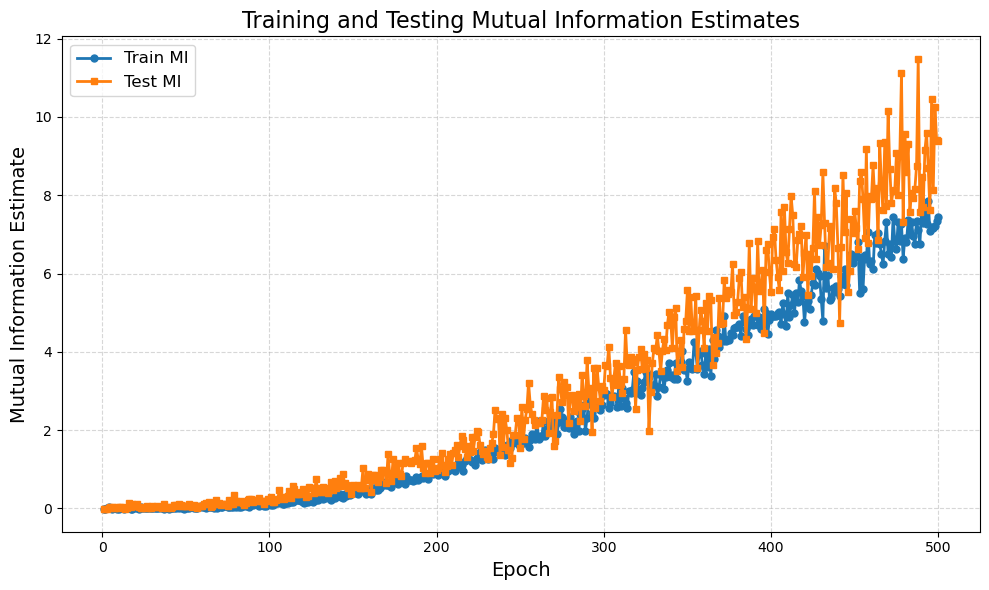

In [26]:


plt.figure(figsize=(10,6))
epochs = range(1, len(train_mi_history) + 1)

# Plotting Train MI
plt.plot(epochs, train_mi_history, '-o', linewidth=2, markersize=5, label='Train MI')

# Plotting Test MI
plt.plot(epochs, test_mi_history, '-s', linewidth=2, markersize=5, label='Test MI')

# Labels and Title
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mutual Information Estimate', fontsize=14)
plt.title('Training and Testing Mutual Information Estimates', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend 
plt.legend(fontsize=12)


plt.tight_layout()

plt.show()


In [29]:
critic_model.eval()

odorant_joint_scores = {i: [] for i in range(10)}
odorant_marginal_scores = {i: [] for i in range(10)}

with torch.no_grad():
    for odor_labels, joint_imgs, marginal_imgs in test_loader:
        odor_labels = odor_labels.to(device)
        joint_imgs = joint_imgs.to(device)
        marginal_imgs = marginal_imgs.to(device)

        joint_out = critic_model(odor_labels, joint_imgs).cpu().numpy().flatten()
        marginal_out = critic_model(odor_labels, marginal_imgs).cpu().numpy().flatten()

        for label, j_score, m_score in zip(odor_labels.cpu().numpy(), joint_out, marginal_out):
            odorant_joint_scores[label].append(j_score)
            odorant_marginal_scores[label].append(m_score)


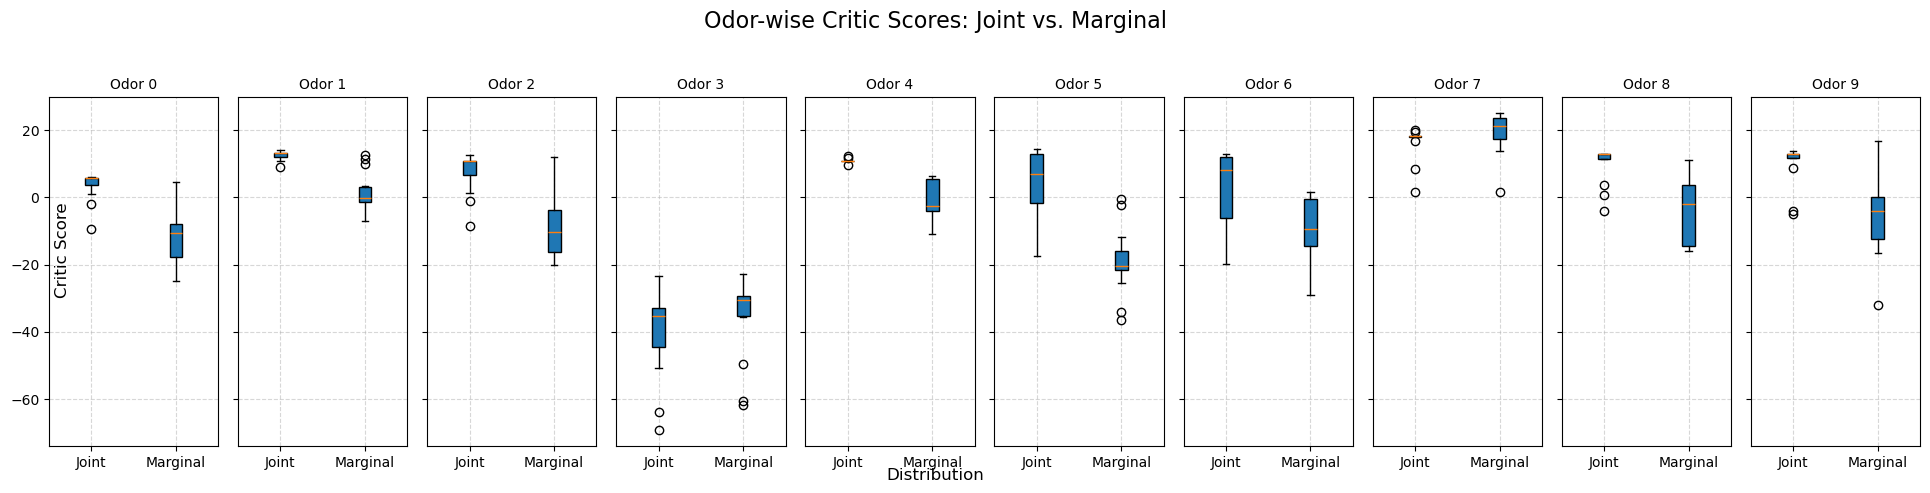

In [31]:
import matplotlib.pyplot as plt

odor_labels = list(range(10))
fig, axes = plt.subplots(1, 10, figsize=(20, 5), sharey=True)

for odor in odor_labels:
    axes[odor].boxplot([odorant_joint_scores[odor], odorant_marginal_scores[odor]],
                       labels=['Joint', 'Marginal'],
                       patch_artist=True)
    axes[odor].set_title(f'Odor {odor}', fontsize=10)
    axes[odor].grid(True, linestyle='--', alpha=0.5)

fig.suptitle('Odor-wise Critic Scores: Joint vs. Marginal', fontsize=16)
fig.text(0.5, 0.04, 'Distribution', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Critic Score', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()


In [32]:
mean_images = {}

for odor in range(10):
    odor_imgs = []
    for idx in range(len(test_dataset)):
        label, joint_img, _ = test_dataset[idx]
        if label == odor:
            odor_imgs.append(joint_img.numpy())
    odor_imgs = np.stack(odor_imgs)
    mean_images[odor] = np.mean(odor_imgs, axis=0).squeeze()


In [33]:
critic_model.eval()

odorant_joint_scores = {i: [] for i in range(10)}
odorant_marginal_scores = {i: [] for i in range(10)}

with torch.no_grad():
    for odor_labels, joint_imgs, marginal_imgs in test_loader:
        odor_labels, joint_imgs, marginal_imgs = odor_labels.to(device), joint_imgs.to(device), marginal_imgs.to(device)

        joint_out = critic_model(odor_labels, joint_imgs).cpu().numpy().flatten()
        marginal_out = critic_model(odor_labels, marginal_imgs).cpu().numpy().flatten()

        for label, j_score, m_score in zip(odor_labels.cpu().numpy(), joint_out, marginal_out):
            odorant_joint_scores[label].append(j_score)
            odorant_marginal_scores[label].append(m_score)


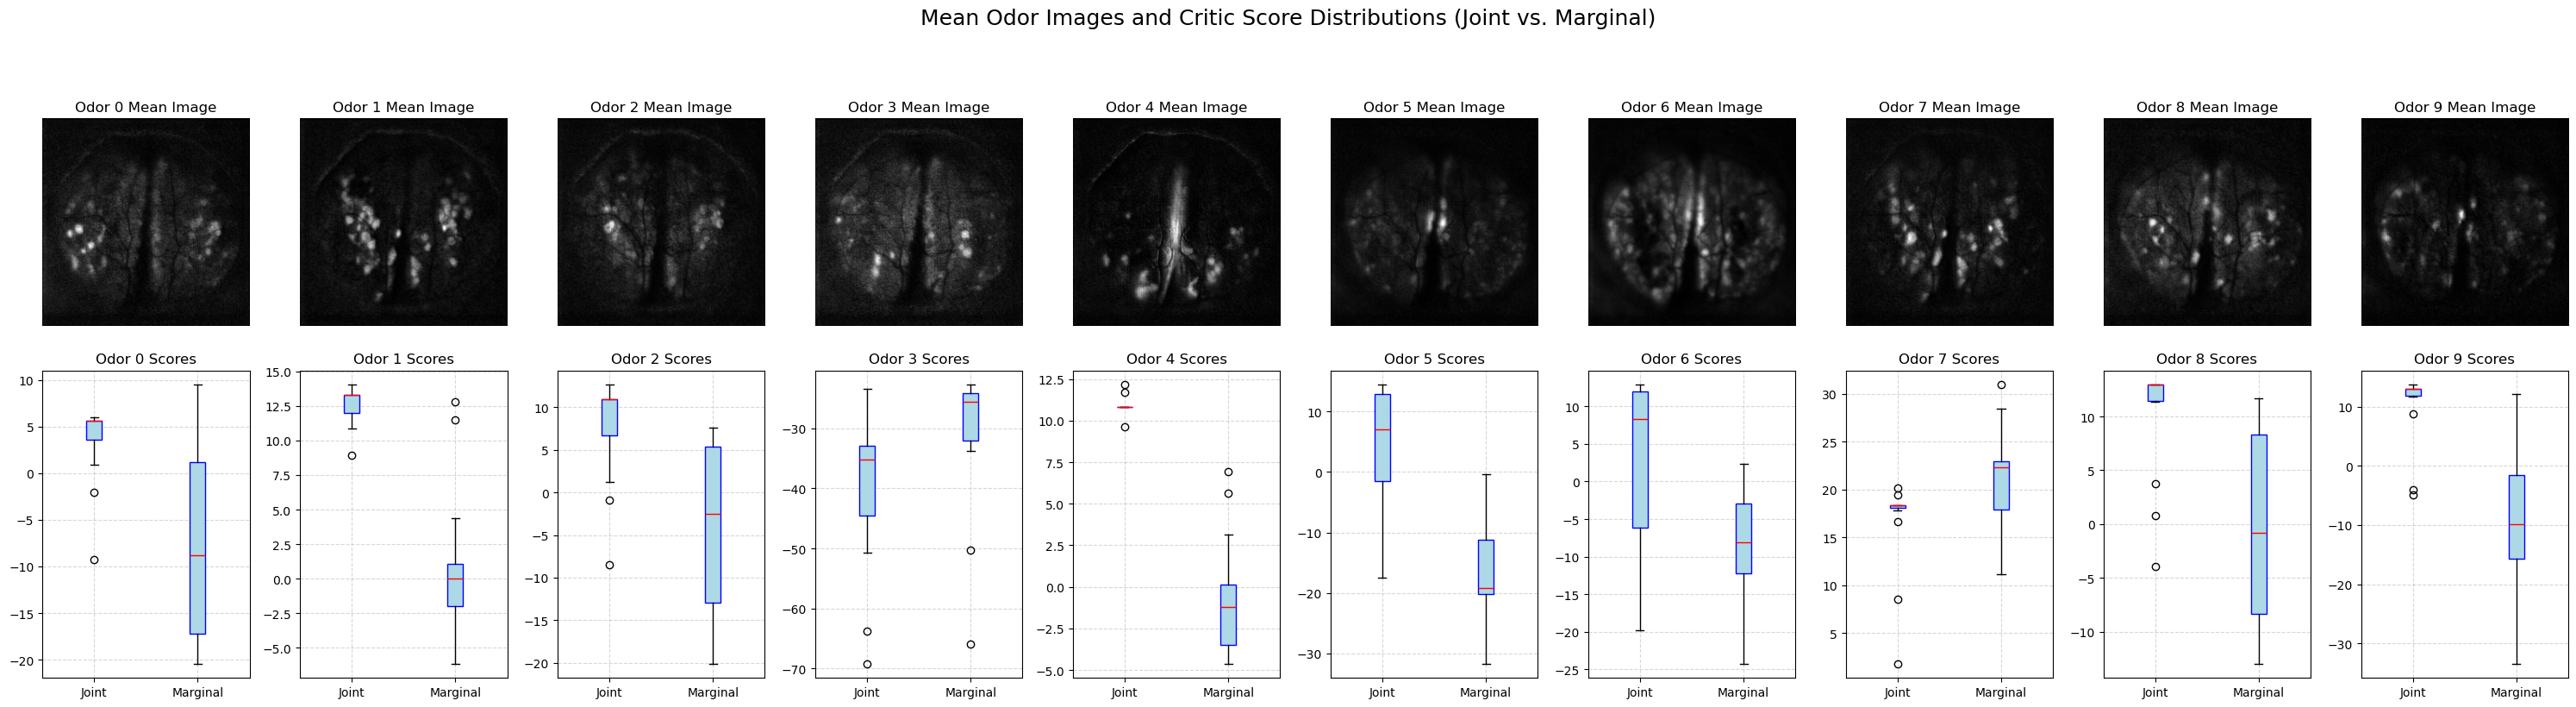

In [34]:
fig, axes = plt.subplots(2, 10, figsize=(30, 8))

for odor in range(10):
    # Plot mean image explicitly (first row)
    axes[0, odor].imshow(mean_images[odor], cmap='gray')
    axes[0, odor].axis('off')
    axes[0, odor].set_title(f'Odor {odor} Mean Image', fontsize=12)

    # Boxplot explicitly (second row)
    axes[1, odor].boxplot(
        [odorant_joint_scores[odor], odorant_marginal_scores[odor]],
        labels=['Joint', 'Marginal'],
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', color='blue'),
        medianprops=dict(color='red')
    )
    axes[1, odor].set_title(f'Odor {odor} Scores', fontsize=12)
    axes[1, odor].grid(True, linestyle='--', alpha=0.5)

fig.suptitle('Mean Odor Images and Critic Score Distributions (Joint vs. Marginal)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


In [35]:
critic_model.eval()

joint_scores, marginal_scores = [], []

with torch.no_grad():
    for odor_labels, joint_imgs, marginal_imgs in test_loader:
        odor_labels = odor_labels.to(device)
        joint_imgs = joint_imgs.to(device)
        marginal_imgs = marginal_imgs.to(device)

        joint_out = critic_model(odor_labels, joint_imgs).cpu().numpy().flatten()
        marginal_out = critic_model(odor_labels, marginal_imgs).cpu().numpy().flatten()

        joint_scores.extend(joint_out)
        marginal_scores.extend(marginal_out)


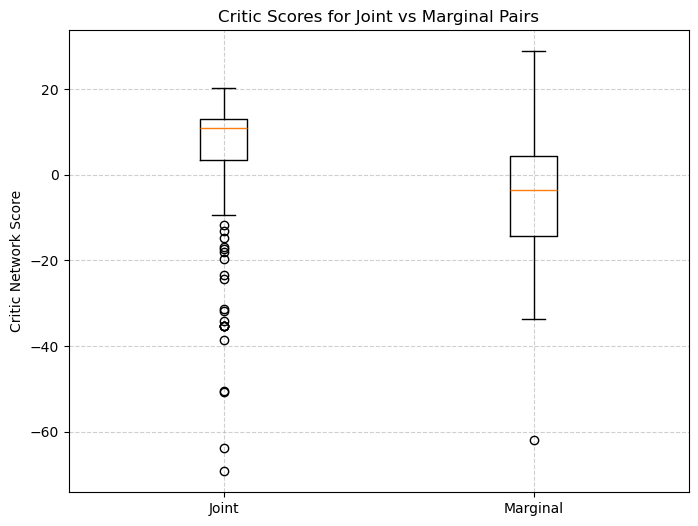

In [36]:
plt.figure(figsize=(8,6))
plt.boxplot([joint_scores, marginal_scores], labels=['Joint', 'Marginal'])
plt.ylabel("Critic Network Score")
plt.title("Critic Scores for Joint vs Marginal Pairs")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


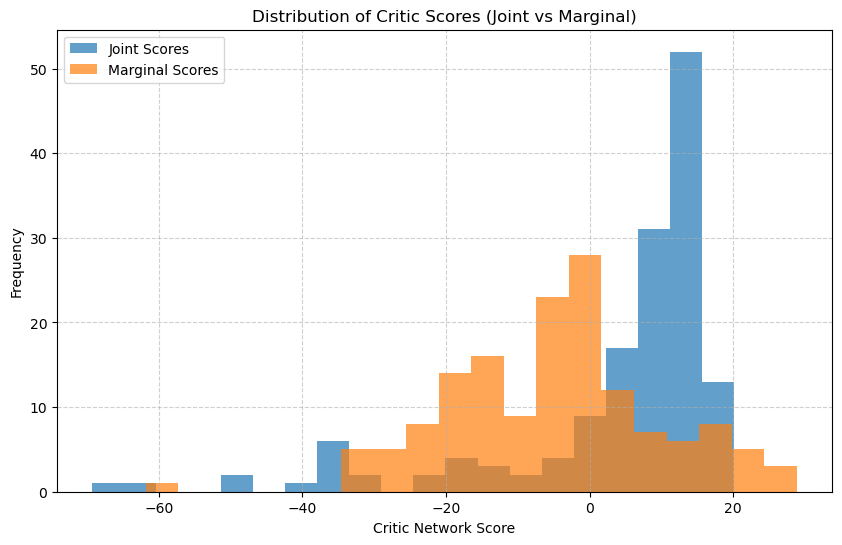

In [37]:
plt.figure(figsize=(10,6))
plt.hist(joint_scores, bins=20, alpha=0.7, label='Joint Scores')
plt.hist(marginal_scores, bins=20, alpha=0.7, label='Marginal Scores')
plt.xlabel("Critic Network Score")
plt.ylabel("Frequency")
plt.title("Distribution of Critic Scores (Joint vs Marginal)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
